# Machine Learning Engineer Nanodegree Capstone Project
Mingpei Yang  
April 03, 2018

## Overview
This notebook contains codes to create a stock trading agent with recurrent reinforcement learning. More detailed explanation in the report pdf.

## Data Preprocessing
In this project, I will to use the adj_close price data of some stocks from Quandl. 

In [19]:
# import packages
import math
import quandl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
quandl.ApiConfig.api_key = "EUyWdnknRD4hPXeac24T"
def acquireData(tickerName, trainStart,trainEnd,testStart,testEnd):
    trainingTickerName = "WIKI/"+tickerName
    trainingTickerStart = trainStart
    trainingTickerEnd = trainEnd
    testingTickerName = "WIKI/"+tickerName
    testingTickerStart = testStart
    testingTickerEnd = testEnd
    feature = "Adj. Close"

    # Get training data.
    trainingData_dataframe = quandl.get(trainingTickerName, start_date=trainingTickerStart, end_date=trainingTickerEnd)
    trainingData = trainingData_dataframe[feature]
    # Get testing data.
    testingData_dataframe = quandl.get(testingTickerName, start_date=testingTickerStart, end_date=testingTickerEnd)
    testingData = testingData_dataframe[feature]

    # Plot training data and testing data.
    fig = plt.figure(figsize=(18,10))
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(trainingData)
    ax.set_title("Training data: " + trainingTickerName + " " + feature, fontsize = '15')
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.set_title("Testing data: " + testingTickerName + " " + feature, fontsize = '15')
    ax2.plot(testingData)
    return trainingData,testingData

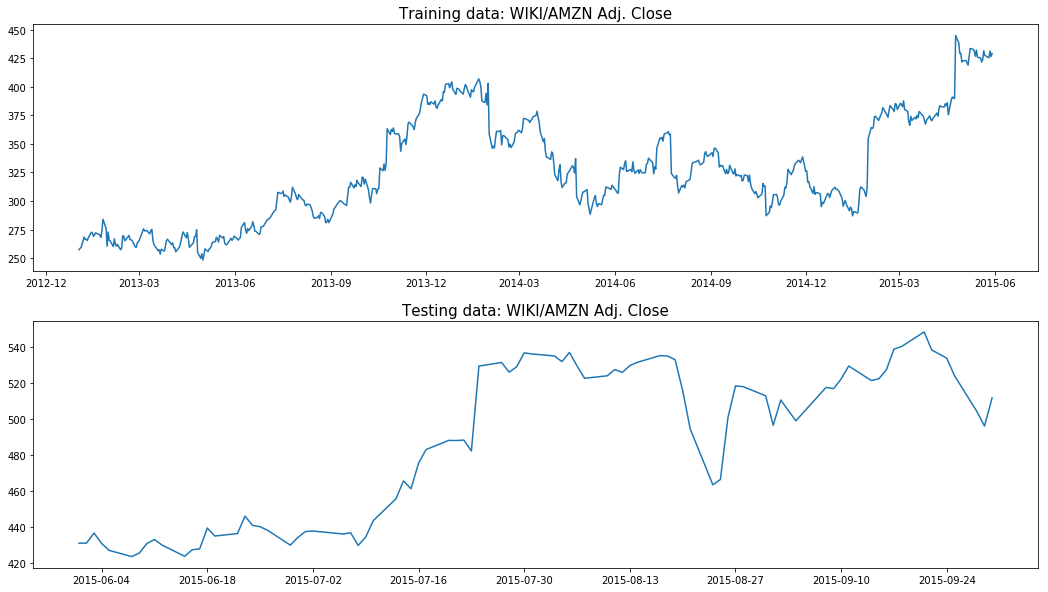

In [213]:
amzn_trainingData, amzn_testingData = acquireData("AMZN","2013-01-02","2015-05-29","2015-06-01","2015-09-30")

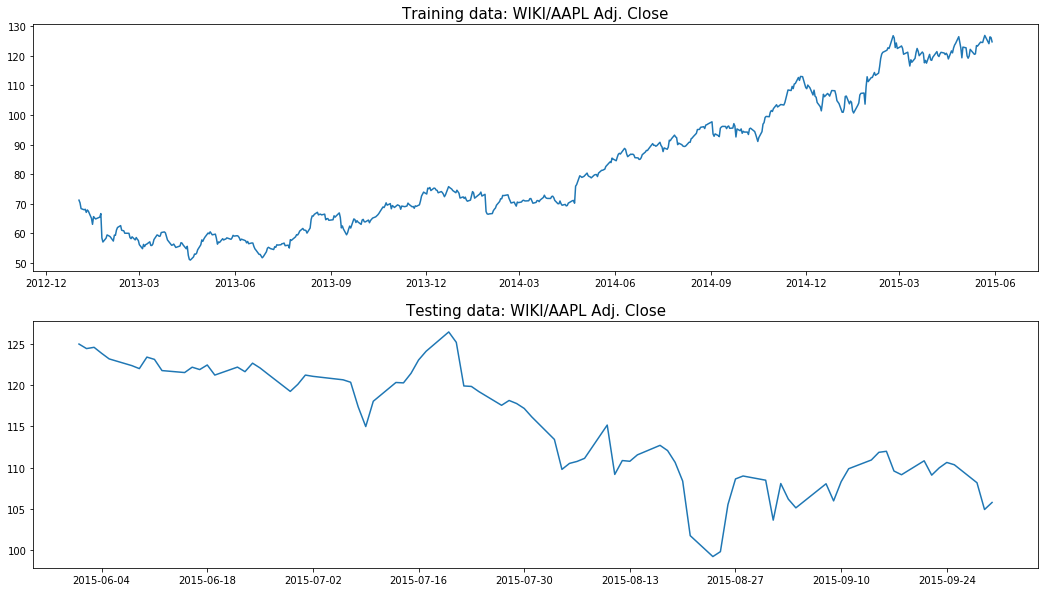

In [214]:
aapl_trainingData, aapl_testingData = acquireData("AAPL","2013-01-02","2015-05-29","2015-06-01","2015-09-30")

Backup Functions to read the local csv file incase the quandl package doesn't work.

In [17]:
import csv
with open('AMZN_train.csv') as csvfile:
    trainData = csv.reader(csvfile, delimiter=',')
    amzn_trainingData = []
    for row in trainData:
        amzn_trainingData.append(float(row[1]))
with open('AMZN_test.csv') as csvfile:
    trainData = csv.reader(csvfile, delimiter=',')
    amzn_testingData = []
    for row in trainData:
        amzn_testingData.append(float(row[1]))
with open('AAPL_train.csv') as csvfile:
    trainData = csv.reader(csvfile, delimiter=',')
    aapl_trainingData = []
    for row in trainData:
        aapl_trainingData.append(float(row[1]))
with open('AAPL_test.csv') as csvfile:
    trainData = csv.reader(csvfile, delimiter=',')
    aapl_testingData = []
    for row in trainData:
        aapl_testingData.append(float(row[1]))

descriptive statistics

In [18]:
import pandas as pd

print("amzn_trainingData summary statistics:\n")
amzn_trainingData_df = pd.DataFrame(amzn_trainingData)
print(amzn_trainingData_df.describe())

print("amzn_testingData summary statistics:\n")
amzn_testingData_df = pd.DataFrame(amzn_testingData)
print(amzn_testingData_df.describe())

print("aapl_trainingData summary statistics:\n")
aapl_trainingData_df = pd.DataFrame(aapl_trainingData)
print(aapl_trainingData_df.describe())

print("aapl_testingData summary statistics:\n")
aapl_testingData_df = pd.DataFrame(aapl_testingData)
print(aapl_testingData_df.describe())

amzn_trainingData summary statistics:

                0
count  606.000000
mean   325.371321
std     45.857944
min    248.229996
25%    292.262489
50%    317.610001
75%    361.612504
max    445.100006
amzn_testingData summary statistics:

                0
count   86.000000
mean   486.937445
std     42.926010
min    423.500000
25%    437.470009
50%    497.770005
75%    527.442520
max    548.390015
aapl_trainingData summary statistics:

                0
count  606.000000
mean    81.833130
std     22.101402
min     50.928800
25%     63.804068
50%     73.090046
75%     97.336937
max    126.931724
aapl_testingData summary statistics:

                0
count   86.000000
mean   115.130454
std      6.932353
min     99.202644
25%    109.641563
50%    115.669685
75%    121.525586
max    126.481611


## Implementation

Next, we will build our recurrent reinforcement learning agent. Here are the main steps:
1. Write function to acquire the data we need and separate them into train and test dataset.
2. Write functions to calculate States, Positions, Immediate reward, Utility and gradients.
3. Write function to train and test the model.
4. Search for optimal policy.

### Step 1. The first step is already implemented in preprocessing part.
### Step 2. Functions to calculate States, Positions, Immediate reward, Utility and gradients.

In [24]:
# Commission Rate
com = 0.05    

#   States Xt:
#   We calculate the States Xt by append the adj_close price into the increment series
def increment(list):
    increList = []
    lengthList = len(list)
    increList.append(0)
    for i in range(1, lengthList):
        increList.append(list[i] - list[i-1])
    return increList

#   This is a helper function to calculate increment vector of length n
def incVector(length, index, list):
    incVector = list[index - length + 1: index + 1]
    return incVector

#   Position Ft
#   Calculate the value of position Ft
def position(list, weight, prepos):
    weightList = np.append([1], np.append(np.array(list), [prepos]))
    weightList = weightList.reshape([len(list)+2, 1])
    pos = np.dot(weight, weightList)
    return np.tanh(pos), weightList

#   Now we constract the position vector with the posVector function
def posVector(wt, length, increList, n):
    posVec = np.zeros([1, n])
    for i in range(length, n):
        posList = incVector(length, i, increList)
        prepos = posVec[0][i-1]
        pos, wl = position(posList, wt, prepos)
        if abs(pos) <= 0.7:
            posVec[0][i] = 0
        else:
            posVec[0][i] = np.sign(pos)
    return posVec

#   This function calculate the immediate rewards Rt
def sumReturn(pos, inc, n):
    sr = np.zeros([1, n])
    srsquire = np.zeros([1, n])
    srtotal = np.zeros([1,n])
    for i in range(1, n):
        sr[0][i] = (pos[0][i-1] * inc[i] - com * abs(pos[0][i] - pos[0][i-1]))
        srsquire[0][i] = sr[0][i] ** 2
        srtotal[0][i] = sr.sum()
    sumsr = sr.sum()
    sumsrsq = srsquire.sum()
    # print(sr)
    return sumsr, sumsrsq, srtotal

#  Calculate the sharp ratio which is the Utility
def sharpRatio(weight, length,posVec, increList, n):
    sumsr, sumsrsq, total = sumReturn(posVec, increList, n)
    A = sumsr / n
    B = sumsrsq / n
    sharpRatio = A / math.sqrt(B - (A**2))
    return sharpRatio, float(A), float(B)


#   Calculate the gradient of position vector
def posGradient(weight, length, posVec, increList, n):
    posVec = posVector(weight, length, increList, n)
    posGrad = np.zeros([n, length+2])
    for i in range(length, n):
        posList = incVector(length, i, increList)
        prepos = posVec[0][i-1]
        pos, wl = position(posList, weight, prepos)
        # print(np.shape(posGrad[i-1, ]))
        posGrad[i, ] = (1 - pos ** 2) * (wl.transpose() + posGrad[i-1, ] * weight[0, length+1])
    return posGrad

#   Calculate the gradient of Sharp Ratio
def sharpGradient(weight, length, posVec, increList, n):
    pGrad = posGradient(weight, length, posVec, increList, n)
    sRatio, A, B = sharpRatio(weight, length,posVec, increList, n)
    dST_dA = (B - A**2) ** (-0.5) + (A ** 2) * (B - A**2) ** (-1.5)
    dST_dB = (-0.5) * A * ((B - A**2) ** (-1.5))
    dA_dRi = float(1 / n)
    sharpGrad = np.zeros([n, length+2])
    for i in range(length, n):
        dB_dRi = 2 * dA_dRi * increList[i]
        dRt_dFt = - com * np.sign(posVec[0, i] - posVec[0, i-1])
        dRt_dFpret = (increList[i] + com * np.sign(posVec[0, i] - posVec[0, i-1]))
        sharpGrad[i, ] = (dST_dA * dA_dRi + dST_dB * dB_dRi) * (dRt_dFt * pGrad[i, ] + dRt_dFpret * pGrad[i-1, ])
    sGrad = sharpGrad.sum(axis=0)
    return sGrad

#   The learning function will combine the algorithm functions and update the weight through iterations (step) 
#   with different coefficients and speeds. 
def learning(length, step, increList, n, coef, speed):
    coef = coef
    speed = speed
    weight = coef * np.ones([1, length+2])
    for i in range(1, step+1):
        posVec = posVector(weight, length, increList, n)
        spratio, a, b = sharpRatio(weight, length, posVec, increList, n)
        print("Reinforcement Learning {0} th step, Sharp Ratio: {1}".format(i, spratio))
        spGrad = sharpGradient(weight, length, posVec, increList, n)
        weight += speed * spGrad
    return weight

### Step 3. Train and test the model

In [62]:
def train_test_Model(tickerName, trainingData, testingData, length, step, coef, speed):
    # train
    trainPriceList = trainingData
    trainIncreList = increment(trainPriceList)
    train_n = len(trainPriceList)
    train_weight = learning(length, step, trainIncreList, train_n, coef, speed)
    train_tradeSig = posVector(train_weight, length, trainIncreList, train_n)
    train_sumsr, train_sumsrsq, train_total = sumReturn(train_tradeSig, trainIncreList, train_n)
    
    # test
    test_priceList = testingData
    test_increList = increment(test_priceList)
    test_n = len(test_priceList)
    #test_weight = learning(length, step, test_increList, test_n, coef, speed)
    test_tradeSig = posVector(train_weight, length, test_increList, test_n)
    test_sumsr, test_sumsrsq, test_total = sumReturn(test_tradeSig, test_increList, test_n)
    
    # plot the image of training trading signals.
    plt.plot(train_tradeSig.transpose())
    plt.ylabel('Training Trading Signal')
    plt.show()
    # plot the total return of training model
    plt.plot(train_total.transpose())
    plt.xlabel('Date')
    plt.ylabel('Total Return')
    plt.title(tickerName+" training")
    plt.show()
    
    # plot the image of testing trading signals.
    plt.plot(test_tradeSig.transpose())
    plt.ylabel('Testing Trading Signal')
    plt.show()
    # plot the total return of testing model
    plt.plot(test_total.transpose())
    plt.xlabel('Date')
    plt.ylabel('Total Return')
    plt.title(tickerName+" testing")
    if tickerName == "AMZN":
        line1, = plt.plot([0, 80], [70, 70], label="AMZN_Hold", linestyle='--')
    elif tickerName == "AMZN_robust":
        line1, = plt.plot([0, 80], [-60, -60], label="AMZN_robust_Hold", linestyle='--')
    elif tickerName == "AAPL":
        line1, = plt.plot([0, 80], [-20, -20], label="AAPL_Hold", linewidth=4)
    elif tickerName == "AAPL_robust":
        line1, = plt.plot([0, 80], [-10, -10], label="AAPL_robust_Hold", linewidth=4)
    elif tickerName == "PEP":
        line1, = plt.plot([0, 80], [4, 4], label="PEP_Hold", linewidth=4)
    elif tickerName == "NVDA":
        line1, = plt.plot([0, 80], [4, 4], label="NVDA_Hold", linewidth=4)

    first_legend = plt.legend(handles=[line1], loc=1)
    ax = plt.gca().add_artist(first_legend)
    plt.show()

### Step 4. Search for optimal policy.

Reinforcement Learning 1 th step, Sharp Ratio: -0.05882439420224372
Reinforcement Learning 2 th step, Sharp Ratio: 0.02471401750618455
Reinforcement Learning 3 th step, Sharp Ratio: 0.03162766964913885
Reinforcement Learning 4 th step, Sharp Ratio: 0.0325130081896496
Reinforcement Learning 5 th step, Sharp Ratio: 0.04472435719933988
Reinforcement Learning 6 th step, Sharp Ratio: 0.07153656239858892
Reinforcement Learning 7 th step, Sharp Ratio: 0.08724150363241603
Reinforcement Learning 8 th step, Sharp Ratio: 0.1022138683793563
Reinforcement Learning 9 th step, Sharp Ratio: 0.1091485875259214
Reinforcement Learning 10 th step, Sharp Ratio: 0.10772326670838826
Reinforcement Learning 11 th step, Sharp Ratio: 0.10646755386686672
Reinforcement Learning 12 th step, Sharp Ratio: 0.13381944846457106
Reinforcement Learning 13 th step, Sharp Ratio: 0.13071278271204687
Reinforcement Learning 14 th step, Sharp Ratio: 0.14279930268783056
Reinforcement Learning 15 th step, Sharp Ratio: 0.138169046

Reinforcement Learning 125 th step, Sharp Ratio: 0.1631731522286593
Reinforcement Learning 126 th step, Sharp Ratio: 0.16127587259275078
Reinforcement Learning 127 th step, Sharp Ratio: 0.1631731522286593
Reinforcement Learning 128 th step, Sharp Ratio: 0.16127587259275078
Reinforcement Learning 129 th step, Sharp Ratio: 0.16303701694933276
Reinforcement Learning 130 th step, Sharp Ratio: 0.16127587259275078
Reinforcement Learning 131 th step, Sharp Ratio: 0.16303701694933276
Reinforcement Learning 132 th step, Sharp Ratio: 0.1625993868159208
Reinforcement Learning 133 th step, Sharp Ratio: 0.16241751976903332
Reinforcement Learning 134 th step, Sharp Ratio: 0.16414225417372372
Reinforcement Learning 135 th step, Sharp Ratio: 0.16241751976903332
Reinforcement Learning 136 th step, Sharp Ratio: 0.16414225417372372
Reinforcement Learning 137 th step, Sharp Ratio: 0.16355791437903253
Reinforcement Learning 138 th step, Sharp Ratio: 0.1643757761922978
Reinforcement Learning 139 th step, Sh

Reinforcement Learning 245 th step, Sharp Ratio: 0.17793956729350763
Reinforcement Learning 246 th step, Sharp Ratio: 0.17793956729350763
Reinforcement Learning 247 th step, Sharp Ratio: 0.17793956729350763
Reinforcement Learning 248 th step, Sharp Ratio: 0.1797176227918061
Reinforcement Learning 249 th step, Sharp Ratio: 0.17916790944076488
Reinforcement Learning 250 th step, Sharp Ratio: 0.17760493721087883
Reinforcement Learning 251 th step, Sharp Ratio: 0.17637635732328172
Reinforcement Learning 252 th step, Sharp Ratio: 0.17760493721087883
Reinforcement Learning 253 th step, Sharp Ratio: 0.17760493721087883
Reinforcement Learning 254 th step, Sharp Ratio: 0.17760493721087883
Reinforcement Learning 255 th step, Sharp Ratio: 0.17760493721087883
Reinforcement Learning 256 th step, Sharp Ratio: 0.17884209825231223
Reinforcement Learning 257 th step, Sharp Ratio: 0.17884209825231223
Reinforcement Learning 258 th step, Sharp Ratio: 0.17884209825231223
Reinforcement Learning 259 th step,

Reinforcement Learning 364 th step, Sharp Ratio: 0.18228787961710702
Reinforcement Learning 365 th step, Sharp Ratio: 0.18228787961710702
Reinforcement Learning 366 th step, Sharp Ratio: 0.18228787961710702
Reinforcement Learning 367 th step, Sharp Ratio: 0.1825150664120674
Reinforcement Learning 368 th step, Sharp Ratio: 0.18228787961710702
Reinforcement Learning 369 th step, Sharp Ratio: 0.18228787961710702
Reinforcement Learning 370 th step, Sharp Ratio: 0.18228787961710702
Reinforcement Learning 371 th step, Sharp Ratio: 0.1825150664120674
Reinforcement Learning 372 th step, Sharp Ratio: 0.18228787961710702
Reinforcement Learning 373 th step, Sharp Ratio: 0.18228787961710702
Reinforcement Learning 374 th step, Sharp Ratio: 0.1825150664120674
Reinforcement Learning 375 th step, Sharp Ratio: 0.18228787961710702
Reinforcement Learning 376 th step, Sharp Ratio: 0.1825150664120674
Reinforcement Learning 377 th step, Sharp Ratio: 0.18228787961710702
Reinforcement Learning 378 th step, Sh

Reinforcement Learning 488 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 489 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 490 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 491 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 492 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 493 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 494 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 495 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 496 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 497 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 498 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 499 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 500 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 501 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 502 th step

Reinforcement Learning 607 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 608 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 609 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 610 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 611 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 612 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 613 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 614 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 615 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 616 th step, Sharp Ratio: 0.18169139330241207
Reinforcement Learning 617 th step, Sharp Ratio: 0.18365876430110778
Reinforcement Learning 618 th step, Sharp Ratio: 0.18365876430110778
Reinforcement Learning 619 th step, Sharp Ratio: 0.18365876430110778
Reinforcement Learning 620 th step, Sharp Ratio: 0.18365876430110778
Reinforcement Learning 621 th step

Reinforcement Learning 730 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 731 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 732 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 733 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 734 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 735 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 736 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 737 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 738 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 739 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 740 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 741 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 742 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 743 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 744 th step

Reinforcement Learning 850 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 851 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 852 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 853 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 854 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 855 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 856 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 857 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 858 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 859 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 860 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 861 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 862 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 863 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 864 th step

Reinforcement Learning 972 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 973 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 974 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 975 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 976 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 977 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 978 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 979 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 980 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 981 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 982 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 983 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 984 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 985 th step, Sharp Ratio: 0.18660099979661732
Reinforcement Learning 986 th step

Reinforcement Learning 121 th step, Sharp Ratio: 0.3320996176730795
Reinforcement Learning 122 th step, Sharp Ratio: 0.3320996176730795
Reinforcement Learning 123 th step, Sharp Ratio: 0.3320996176730795
Reinforcement Learning 124 th step, Sharp Ratio: 0.3320996176730795
Reinforcement Learning 125 th step, Sharp Ratio: 0.3320996176730795
Reinforcement Learning 126 th step, Sharp Ratio: 0.3320996176730795
Reinforcement Learning 127 th step, Sharp Ratio: 0.3320996176730795
Reinforcement Learning 128 th step, Sharp Ratio: 0.3320996176730795
Reinforcement Learning 129 th step, Sharp Ratio: 0.3320996176730795
Reinforcement Learning 130 th step, Sharp Ratio: 0.3320996176730795
Reinforcement Learning 131 th step, Sharp Ratio: 0.3320996176730795
Reinforcement Learning 132 th step, Sharp Ratio: 0.3320996176730795
Reinforcement Learning 133 th step, Sharp Ratio: 0.3320996176730795
Reinforcement Learning 134 th step, Sharp Ratio: 0.3320996176730795
Reinforcement Learning 135 th step, Sharp Ratio:

Reinforcement Learning 279 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 280 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 281 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 282 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 283 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 284 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 285 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 286 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 287 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 288 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 289 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 290 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 291 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 292 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 293 th step, Sharp Ratio:

Reinforcement Learning 438 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 439 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 440 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 441 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 442 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 443 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 444 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 445 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 446 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 447 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 448 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 449 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 450 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 451 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 452 th step, Sharp Ratio:

Reinforcement Learning 559 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 560 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 561 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 562 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 563 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 564 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 565 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 566 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 567 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 568 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 569 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 570 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 571 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 572 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 573 th step, Sharp Ratio:

Reinforcement Learning 683 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 684 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 685 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 686 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 687 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 688 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 689 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 690 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 691 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 692 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 693 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 694 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 695 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 696 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 697 th step, Sharp Ratio:

Reinforcement Learning 806 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 807 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 808 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 809 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 810 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 811 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 812 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 813 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 814 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 815 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 816 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 817 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 818 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 819 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 820 th step, Sharp Ratio:

Reinforcement Learning 927 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 928 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 929 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 930 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 931 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 932 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 933 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 934 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 935 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 936 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 937 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 938 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 939 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 940 th step, Sharp Ratio: 0.3326581471472029
Reinforcement Learning 941 th step, Sharp Ratio:

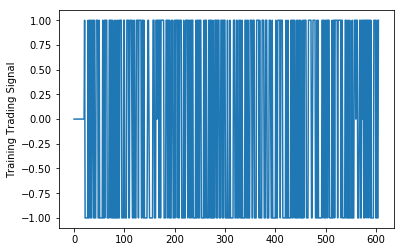

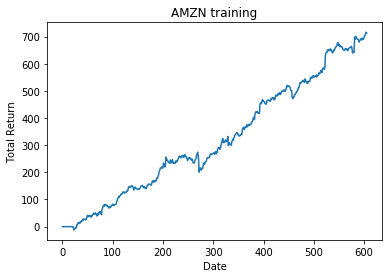

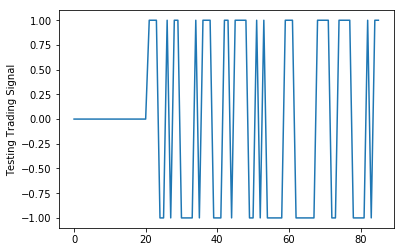

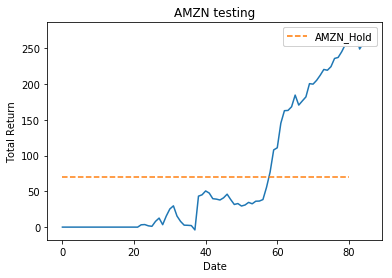

In [224]:
train_test_Model("AMZN", trainingData=amzn_trainingData, testingData=amzn_testingData,
                 length=21, step=1000, coef=0.02, speed=0.3)

Reinforcement Learning 1 th step, Sharp Ratio: -0.010261222914279855
Reinforcement Learning 2 th step, Sharp Ratio: 0.03191358799150216
Reinforcement Learning 3 th step, Sharp Ratio: 0.06145133340294148
Reinforcement Learning 4 th step, Sharp Ratio: 0.09770424449283226
Reinforcement Learning 5 th step, Sharp Ratio: 0.09294280564280404
Reinforcement Learning 6 th step, Sharp Ratio: 0.10962892954408553
Reinforcement Learning 7 th step, Sharp Ratio: 0.11219470159708568
Reinforcement Learning 8 th step, Sharp Ratio: 0.13212198226693503
Reinforcement Learning 9 th step, Sharp Ratio: 0.1446123085283093
Reinforcement Learning 10 th step, Sharp Ratio: 0.1343570235849381
Reinforcement Learning 11 th step, Sharp Ratio: 0.13882989750803537
Reinforcement Learning 12 th step, Sharp Ratio: 0.1529013673332039
Reinforcement Learning 13 th step, Sharp Ratio: 0.16028476705136555
Reinforcement Learning 14 th step, Sharp Ratio: 0.16174462538109832
Reinforcement Learning 15 th step, Sharp Ratio: 0.15999482

Reinforcement Learning 123 th step, Sharp Ratio: 0.1885484062451677
Reinforcement Learning 124 th step, Sharp Ratio: 0.18717045993504694
Reinforcement Learning 125 th step, Sharp Ratio: 0.1885484062451677
Reinforcement Learning 126 th step, Sharp Ratio: 0.18717045993504694
Reinforcement Learning 127 th step, Sharp Ratio: 0.1885484062451677
Reinforcement Learning 128 th step, Sharp Ratio: 0.18717045993504694
Reinforcement Learning 129 th step, Sharp Ratio: 0.1885484062451677
Reinforcement Learning 130 th step, Sharp Ratio: 0.1885484062451677
Reinforcement Learning 131 th step, Sharp Ratio: 0.1885484062451677
Reinforcement Learning 132 th step, Sharp Ratio: 0.19045395573131124
Reinforcement Learning 133 th step, Sharp Ratio: 0.1885484062451677
Reinforcement Learning 134 th step, Sharp Ratio: 0.19045395573131124
Reinforcement Learning 135 th step, Sharp Ratio: 0.1885484062451677
Reinforcement Learning 136 th step, Sharp Ratio: 0.19045395573131124
Reinforcement Learning 137 th step, Sharp 

Reinforcement Learning 244 th step, Sharp Ratio: 0.19213204366273393
Reinforcement Learning 245 th step, Sharp Ratio: 0.19213204366273393
Reinforcement Learning 246 th step, Sharp Ratio: 0.19213204366273393
Reinforcement Learning 247 th step, Sharp Ratio: 0.19213204366273393
Reinforcement Learning 248 th step, Sharp Ratio: 0.19213204366273393
Reinforcement Learning 249 th step, Sharp Ratio: 0.19213204366273393
Reinforcement Learning 250 th step, Sharp Ratio: 0.19213204366273393
Reinforcement Learning 251 th step, Sharp Ratio: 0.19213204366273393
Reinforcement Learning 252 th step, Sharp Ratio: 0.19213204366273393
Reinforcement Learning 253 th step, Sharp Ratio: 0.19213204366273393
Reinforcement Learning 254 th step, Sharp Ratio: 0.19213204366273393
Reinforcement Learning 255 th step, Sharp Ratio: 0.19213204366273393
Reinforcement Learning 256 th step, Sharp Ratio: 0.19213204366273393
Reinforcement Learning 257 th step, Sharp Ratio: 0.19213204366273393
Reinforcement Learning 258 th step

Reinforcement Learning 363 th step, Sharp Ratio: 0.19486732537477672
Reinforcement Learning 364 th step, Sharp Ratio: 0.19486732537477672
Reinforcement Learning 365 th step, Sharp Ratio: 0.19486732537477672
Reinforcement Learning 366 th step, Sharp Ratio: 0.19486732537477672
Reinforcement Learning 367 th step, Sharp Ratio: 0.19486732537477672
Reinforcement Learning 368 th step, Sharp Ratio: 0.19486732537477672
Reinforcement Learning 369 th step, Sharp Ratio: 0.19486732537477672
Reinforcement Learning 370 th step, Sharp Ratio: 0.19486732537477672
Reinforcement Learning 371 th step, Sharp Ratio: 0.19486732537477672
Reinforcement Learning 372 th step, Sharp Ratio: 0.19486732537477672
Reinforcement Learning 373 th step, Sharp Ratio: 0.19486732537477672
Reinforcement Learning 374 th step, Sharp Ratio: 0.19486732537477672
Reinforcement Learning 375 th step, Sharp Ratio: 0.19486732537477672
Reinforcement Learning 376 th step, Sharp Ratio: 0.19486732537477672
Reinforcement Learning 377 th step

Reinforcement Learning 483 th step, Sharp Ratio: 0.19609552066945493
Reinforcement Learning 484 th step, Sharp Ratio: 0.19824960694132432
Reinforcement Learning 485 th step, Sharp Ratio: 0.19824960694132432
Reinforcement Learning 486 th step, Sharp Ratio: 0.19814235272416048
Reinforcement Learning 487 th step, Sharp Ratio: 0.19609552066945493
Reinforcement Learning 488 th step, Sharp Ratio: 0.19824960694132432
Reinforcement Learning 489 th step, Sharp Ratio: 0.19824960694132432
Reinforcement Learning 490 th step, Sharp Ratio: 0.19814235272416048
Reinforcement Learning 491 th step, Sharp Ratio: 0.19609552066945493
Reinforcement Learning 492 th step, Sharp Ratio: 0.19824960694132432
Reinforcement Learning 493 th step, Sharp Ratio: 0.19824960694132432
Reinforcement Learning 494 th step, Sharp Ratio: 0.19814235272416048
Reinforcement Learning 495 th step, Sharp Ratio: 0.19609552066945493
Reinforcement Learning 496 th step, Sharp Ratio: 0.19824960694132432
Reinforcement Learning 497 th step

Reinforcement Learning 723 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 724 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 725 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 726 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 727 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 728 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 729 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 730 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 731 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 732 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 733 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 734 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 735 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 736 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 737 th step

Reinforcement Learning 845 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 846 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 847 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 848 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 849 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 850 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 851 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 852 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 853 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 854 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 855 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 856 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 857 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 858 th step, Sharp Ratio: 0.20364365646338947
Reinforcement Learning 859 th step

Reinforcement Learning 965 th step, Sharp Ratio: 0.20460324677909647
Reinforcement Learning 966 th step, Sharp Ratio: 0.20460324677909647
Reinforcement Learning 967 th step, Sharp Ratio: 0.20460324677909647
Reinforcement Learning 968 th step, Sharp Ratio: 0.20460324677909647
Reinforcement Learning 969 th step, Sharp Ratio: 0.20460324677909647
Reinforcement Learning 970 th step, Sharp Ratio: 0.20460324677909647
Reinforcement Learning 971 th step, Sharp Ratio: 0.20460324677909647
Reinforcement Learning 972 th step, Sharp Ratio: 0.20460324677909647
Reinforcement Learning 973 th step, Sharp Ratio: 0.20460324677909647
Reinforcement Learning 974 th step, Sharp Ratio: 0.20460324677909647
Reinforcement Learning 975 th step, Sharp Ratio: 0.20460324677909647
Reinforcement Learning 976 th step, Sharp Ratio: 0.20460324677909647
Reinforcement Learning 977 th step, Sharp Ratio: 0.20460324677909647
Reinforcement Learning 978 th step, Sharp Ratio: 0.20460324677909647
Reinforcement Learning 979 th step

Reinforcement Learning 92 th step, Sharp Ratio: 0.358367469734575
Reinforcement Learning 93 th step, Sharp Ratio: 0.358367469734575
Reinforcement Learning 94 th step, Sharp Ratio: 0.358367469734575
Reinforcement Learning 95 th step, Sharp Ratio: 0.358367469734575
Reinforcement Learning 96 th step, Sharp Ratio: 0.358367469734575
Reinforcement Learning 97 th step, Sharp Ratio: 0.358367469734575
Reinforcement Learning 98 th step, Sharp Ratio: 0.358367469734575
Reinforcement Learning 99 th step, Sharp Ratio: 0.358367469734575
Reinforcement Learning 100 th step, Sharp Ratio: 0.358367469734575
Reinforcement Learning 101 th step, Sharp Ratio: 0.358367469734575
Reinforcement Learning 102 th step, Sharp Ratio: 0.358367469734575
Reinforcement Learning 103 th step, Sharp Ratio: 0.358367469734575
Reinforcement Learning 104 th step, Sharp Ratio: 0.358367469734575
Reinforcement Learning 105 th step, Sharp Ratio: 0.358367469734575
Reinforcement Learning 106 th step, Sharp Ratio: 0.358367469734575
Rei

Reinforcement Learning 248 th step, Sharp Ratio: 0.3035432637321166
Reinforcement Learning 249 th step, Sharp Ratio: 0.3140991837660907
Reinforcement Learning 250 th step, Sharp Ratio: 0.31867193419790185
Reinforcement Learning 251 th step, Sharp Ratio: 0.31867193419790185
Reinforcement Learning 252 th step, Sharp Ratio: 0.31867193419790185
Reinforcement Learning 253 th step, Sharp Ratio: 0.31867193419790185
Reinforcement Learning 254 th step, Sharp Ratio: 0.31867193419790185
Reinforcement Learning 255 th step, Sharp Ratio: 0.31867193419790185
Reinforcement Learning 256 th step, Sharp Ratio: 0.31867193419790185
Reinforcement Learning 257 th step, Sharp Ratio: 0.31867193419790185
Reinforcement Learning 258 th step, Sharp Ratio: 0.31867193419790185
Reinforcement Learning 259 th step, Sharp Ratio: 0.31867193419790185
Reinforcement Learning 260 th step, Sharp Ratio: 0.31867193419790185
Reinforcement Learning 261 th step, Sharp Ratio: 0.31867193419790185
Reinforcement Learning 262 th step, 

Reinforcement Learning 489 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 490 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 491 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 492 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 493 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 494 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 495 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 496 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 497 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 498 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 499 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 500 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 501 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 502 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 503 th step

Reinforcement Learning 645 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 646 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 647 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 648 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 649 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 650 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 651 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 652 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 653 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 654 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 655 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 656 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 657 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 658 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 659 th step

Reinforcement Learning 764 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 765 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 766 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 767 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 768 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 769 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 770 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 771 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 772 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 773 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 774 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 775 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 776 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 777 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 778 th step

Reinforcement Learning 887 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 888 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 889 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 890 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 891 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 892 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 893 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 894 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 895 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 896 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 897 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 898 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 899 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 900 th step, Sharp Ratio: 0.36796562678788924
Reinforcement Learning 901 th step

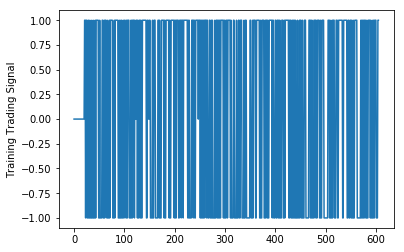

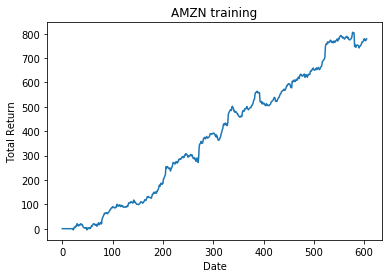

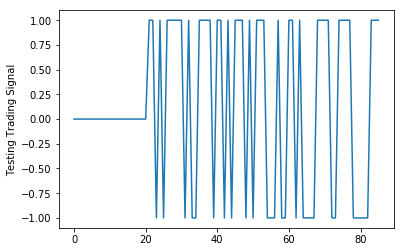

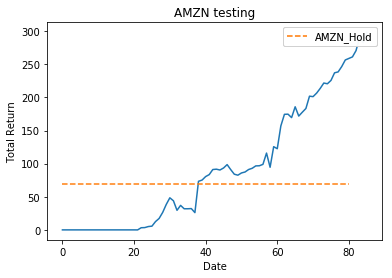

In [225]:
train_test_Model("AMZN", trainingData=amzn_trainingData, testingData=amzn_testingData,
                 length=21, step=1000, coef=0.1, speed=0.5)

Reinforcement Learning 1 th step, Sharp Ratio: -0.020631123015010376
Reinforcement Learning 2 th step, Sharp Ratio: 0.0039594521316094165
Reinforcement Learning 3 th step, Sharp Ratio: 0.018445514822522883
Reinforcement Learning 4 th step, Sharp Ratio: 0.02317915608307461
Reinforcement Learning 5 th step, Sharp Ratio: 0.024069294430876118
Reinforcement Learning 6 th step, Sharp Ratio: 0.029142443303304358
Reinforcement Learning 7 th step, Sharp Ratio: 0.030604598782689705
Reinforcement Learning 8 th step, Sharp Ratio: 0.03165018585816406
Reinforcement Learning 9 th step, Sharp Ratio: 0.053035451948940694
Reinforcement Learning 10 th step, Sharp Ratio: 0.054997725426623026
Reinforcement Learning 11 th step, Sharp Ratio: 0.05643900655128594
Reinforcement Learning 12 th step, Sharp Ratio: 0.05822081919683099
Reinforcement Learning 13 th step, Sharp Ratio: 0.05874179123125167
Reinforcement Learning 14 th step, Sharp Ratio: 0.060341929470511355
Reinforcement Learning 15 th step, Sharp Ratio

Reinforcement Learning 126 th step, Sharp Ratio: 0.11482103277291193
Reinforcement Learning 127 th step, Sharp Ratio: 0.11482103277291193
Reinforcement Learning 128 th step, Sharp Ratio: 0.11379033202283022
Reinforcement Learning 129 th step, Sharp Ratio: 0.11379033202283022
Reinforcement Learning 130 th step, Sharp Ratio: 0.11379033202283022
Reinforcement Learning 131 th step, Sharp Ratio: 0.11379033202283022
Reinforcement Learning 132 th step, Sharp Ratio: 0.11379033202283022
Reinforcement Learning 133 th step, Sharp Ratio: 0.11379033202283022
Reinforcement Learning 134 th step, Sharp Ratio: 0.11379033202283022
Reinforcement Learning 135 th step, Sharp Ratio: 0.11379033202283022
Reinforcement Learning 136 th step, Sharp Ratio: 0.11379033202283022
Reinforcement Learning 137 th step, Sharp Ratio: 0.11379033202283022
Reinforcement Learning 138 th step, Sharp Ratio: 0.11506090354549502
Reinforcement Learning 139 th step, Sharp Ratio: 0.11506090354549502
Reinforcement Learning 140 th step

Reinforcement Learning 250 th step, Sharp Ratio: 0.12036158912639384
Reinforcement Learning 251 th step, Sharp Ratio: 0.12036158912639384
Reinforcement Learning 252 th step, Sharp Ratio: 0.12036158912639384
Reinforcement Learning 253 th step, Sharp Ratio: 0.12036158912639384
Reinforcement Learning 254 th step, Sharp Ratio: 0.12036158912639384
Reinforcement Learning 255 th step, Sharp Ratio: 0.12036158912639384
Reinforcement Learning 256 th step, Sharp Ratio: 0.12036158912639384
Reinforcement Learning 257 th step, Sharp Ratio: 0.12036158912639384
Reinforcement Learning 258 th step, Sharp Ratio: 0.12036158912639384
Reinforcement Learning 259 th step, Sharp Ratio: 0.12036158912639384
Reinforcement Learning 260 th step, Sharp Ratio: 0.12036158912639384
Reinforcement Learning 261 th step, Sharp Ratio: 0.12036158912639384
Reinforcement Learning 262 th step, Sharp Ratio: 0.12036158912639384
Reinforcement Learning 263 th step, Sharp Ratio: 0.12036158912639384
Reinforcement Learning 264 th step

Reinforcement Learning 371 th step, Sharp Ratio: 0.12092638178831489
Reinforcement Learning 372 th step, Sharp Ratio: 0.12092638178831489
Reinforcement Learning 373 th step, Sharp Ratio: 0.12092638178831489
Reinforcement Learning 374 th step, Sharp Ratio: 0.12092638178831489
Reinforcement Learning 375 th step, Sharp Ratio: 0.12092638178831489
Reinforcement Learning 376 th step, Sharp Ratio: 0.12092638178831489
Reinforcement Learning 377 th step, Sharp Ratio: 0.12092638178831489
Reinforcement Learning 378 th step, Sharp Ratio: 0.12092638178831489
Reinforcement Learning 379 th step, Sharp Ratio: 0.12092638178831489
Reinforcement Learning 380 th step, Sharp Ratio: 0.12092638178831489
Reinforcement Learning 381 th step, Sharp Ratio: 0.12092638178831489
Reinforcement Learning 382 th step, Sharp Ratio: 0.12092638178831489
Reinforcement Learning 383 th step, Sharp Ratio: 0.12092638178831489
Reinforcement Learning 384 th step, Sharp Ratio: 0.12092638178831489
Reinforcement Learning 385 th step

Reinforcement Learning 612 th step, Sharp Ratio: 0.12456921271188201
Reinforcement Learning 613 th step, Sharp Ratio: 0.12269054619217588
Reinforcement Learning 614 th step, Sharp Ratio: 0.12456921271188201
Reinforcement Learning 615 th step, Sharp Ratio: 0.12269054619217588
Reinforcement Learning 616 th step, Sharp Ratio: 0.1229230318183307
Reinforcement Learning 617 th step, Sharp Ratio: 0.12456921271188201
Reinforcement Learning 618 th step, Sharp Ratio: 0.12269054619217588
Reinforcement Learning 619 th step, Sharp Ratio: 0.12456921271188201
Reinforcement Learning 620 th step, Sharp Ratio: 0.12269054619217588
Reinforcement Learning 621 th step, Sharp Ratio: 0.1229230318183307
Reinforcement Learning 622 th step, Sharp Ratio: 0.12456921271188201
Reinforcement Learning 623 th step, Sharp Ratio: 0.12269054619217588
Reinforcement Learning 624 th step, Sharp Ratio: 0.1229230318183307
Reinforcement Learning 625 th step, Sharp Ratio: 0.12456921271188201
Reinforcement Learning 626 th step, S

Reinforcement Learning 733 th step, Sharp Ratio: 0.12325090149338999
Reinforcement Learning 734 th step, Sharp Ratio: 0.12355798287845013
Reinforcement Learning 735 th step, Sharp Ratio: 0.12520475392188096
Reinforcement Learning 736 th step, Sharp Ratio: 0.12325090149338999
Reinforcement Learning 737 th step, Sharp Ratio: 0.12355798287845013
Reinforcement Learning 738 th step, Sharp Ratio: 0.12520475392188096
Reinforcement Learning 739 th step, Sharp Ratio: 0.12325090149338999
Reinforcement Learning 740 th step, Sharp Ratio: 0.12355798287845013
Reinforcement Learning 741 th step, Sharp Ratio: 0.12520475392188096
Reinforcement Learning 742 th step, Sharp Ratio: 0.12325090149338999
Reinforcement Learning 743 th step, Sharp Ratio: 0.12355798287845013
Reinforcement Learning 744 th step, Sharp Ratio: 0.12520475392188096
Reinforcement Learning 745 th step, Sharp Ratio: 0.12325090149338999
Reinforcement Learning 746 th step, Sharp Ratio: 0.12355798287845013
Reinforcement Learning 747 th step

Reinforcement Learning 855 th step, Sharp Ratio: 0.1269926878177849
Reinforcement Learning 856 th step, Sharp Ratio: 0.1245134599914271
Reinforcement Learning 857 th step, Sharp Ratio: 0.12576568708757185
Reinforcement Learning 858 th step, Sharp Ratio: 0.1245134599914271
Reinforcement Learning 859 th step, Sharp Ratio: 0.12411832592964311
Reinforcement Learning 860 th step, Sharp Ratio: 0.1269926878177849
Reinforcement Learning 861 th step, Sharp Ratio: 0.1245134599914271
Reinforcement Learning 862 th step, Sharp Ratio: 0.12576568708757185
Reinforcement Learning 863 th step, Sharp Ratio: 0.1245134599914271
Reinforcement Learning 864 th step, Sharp Ratio: 0.12411832592964311
Reinforcement Learning 865 th step, Sharp Ratio: 0.1269926878177849
Reinforcement Learning 866 th step, Sharp Ratio: 0.1245134599914271
Reinforcement Learning 867 th step, Sharp Ratio: 0.12576568708757185
Reinforcement Learning 868 th step, Sharp Ratio: 0.1245134599914271
Reinforcement Learning 869 th step, Sharp R

Reinforcement Learning 978 th step, Sharp Ratio: 0.1269926878177849
Reinforcement Learning 979 th step, Sharp Ratio: 0.1245134599914271
Reinforcement Learning 980 th step, Sharp Ratio: 0.12534457503264193
Reinforcement Learning 981 th step, Sharp Ratio: 0.1269926878177849
Reinforcement Learning 982 th step, Sharp Ratio: 0.1245134599914271
Reinforcement Learning 983 th step, Sharp Ratio: 0.1269926878177849
Reinforcement Learning 984 th step, Sharp Ratio: 0.1245134599914271
Reinforcement Learning 985 th step, Sharp Ratio: 0.1269926878177849
Reinforcement Learning 986 th step, Sharp Ratio: 0.1245134599914271
Reinforcement Learning 987 th step, Sharp Ratio: 0.1269926878177849
Reinforcement Learning 988 th step, Sharp Ratio: 0.1245134599914271
Reinforcement Learning 989 th step, Sharp Ratio: 0.1269926878177849
Reinforcement Learning 990 th step, Sharp Ratio: 0.1245134599914271
Reinforcement Learning 991 th step, Sharp Ratio: 0.1269926878177849
Reinforcement Learning 992 th step, Sharp Ratio

Reinforcement Learning 100 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 101 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 102 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 103 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 104 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 105 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 106 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 107 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 108 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 109 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 110 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 111 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 112 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 113 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learni

Reinforcement Learning 222 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 223 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 224 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 225 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 226 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 227 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 228 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 229 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 230 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 231 th step, Sharp Ratio: -0.05057512619506391
Reinforcement Learning 232 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 233 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 234 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 235 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learni

Reinforcement Learning 343 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 344 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 345 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 346 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 347 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 348 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 349 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 350 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 351 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 352 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 353 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 354 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 355 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 356 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learni

Reinforcement Learning 466 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 467 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 468 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 469 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 470 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 471 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 472 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 473 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 474 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 475 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 476 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 477 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 478 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 479 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learni

Reinforcement Learning 616 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 617 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 618 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 619 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 620 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 621 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 622 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 623 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 624 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 625 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 626 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 627 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 628 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 629 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learni

Reinforcement Learning 762 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 763 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 764 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 765 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 766 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 767 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 768 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 769 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 770 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 771 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 772 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 773 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 774 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 775 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learni

Reinforcement Learning 913 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 914 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 915 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 916 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 917 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 918 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 919 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 920 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 921 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 922 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 923 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 924 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 925 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learning 926 th step, Sharp Ratio: -0.05052165883727434
Reinforcement Learni

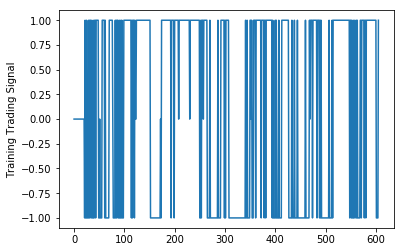

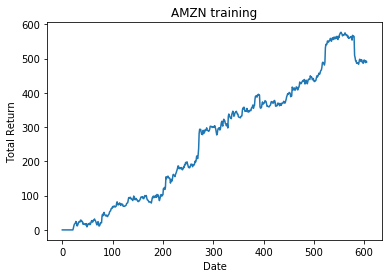

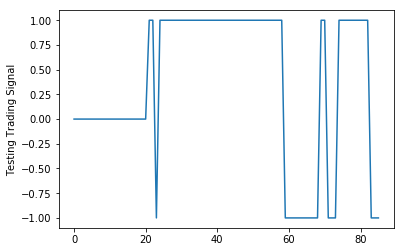

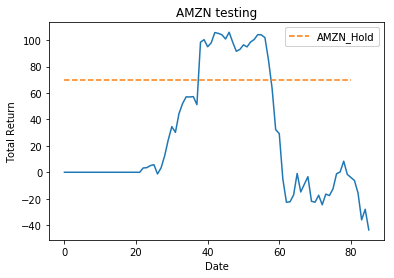

In [226]:
train_test_Model("AMZN", trainingData=amzn_trainingData, testingData=amzn_testingData,
                 length=21, step=1000, coef=0.5, speed=0.5)

Reinforcement Learning 1 th step, Sharp Ratio: -0.02040245600623074
Reinforcement Learning 2 th step, Sharp Ratio: -0.0024379999941716154
Reinforcement Learning 3 th step, Sharp Ratio: 0.00916002642933737
Reinforcement Learning 4 th step, Sharp Ratio: 0.01900990421633513
Reinforcement Learning 5 th step, Sharp Ratio: 0.02345832851515125
Reinforcement Learning 6 th step, Sharp Ratio: 0.027057030457340512
Reinforcement Learning 7 th step, Sharp Ratio: 0.028360301472128757
Reinforcement Learning 8 th step, Sharp Ratio: 0.02953948014475834
Reinforcement Learning 9 th step, Sharp Ratio: 0.029147032412884608
Reinforcement Learning 10 th step, Sharp Ratio: 0.030373223977140578
Reinforcement Learning 11 th step, Sharp Ratio: 0.031586876913618285
Reinforcement Learning 12 th step, Sharp Ratio: 0.031586876913618285
Reinforcement Learning 13 th step, Sharp Ratio: 0.030236046806059097
Reinforcement Learning 14 th step, Sharp Ratio: 0.03274670614822914
Reinforcement Learning 15 th step, Sharp Ratio

Reinforcement Learning 122 th step, Sharp Ratio: 0.05272955646198834
Reinforcement Learning 123 th step, Sharp Ratio: 0.05177589488251173
Reinforcement Learning 124 th step, Sharp Ratio: 0.05272955646198834
Reinforcement Learning 125 th step, Sharp Ratio: 0.052525289934501486
Reinforcement Learning 126 th step, Sharp Ratio: 0.052525289934501486
Reinforcement Learning 127 th step, Sharp Ratio: 0.052525289934501486
Reinforcement Learning 128 th step, Sharp Ratio: 0.052525289934501486
Reinforcement Learning 129 th step, Sharp Ratio: 0.051379090048568034
Reinforcement Learning 130 th step, Sharp Ratio: 0.05272955646198834
Reinforcement Learning 131 th step, Sharp Ratio: 0.05208548533810915
Reinforcement Learning 132 th step, Sharp Ratio: 0.0534354575690276
Reinforcement Learning 133 th step, Sharp Ratio: 0.052525289934501486
Reinforcement Learning 134 th step, Sharp Ratio: 0.053268135383186845
Reinforcement Learning 135 th step, Sharp Ratio: 0.052525289934501486
Reinforcement Learning 136 

Reinforcement Learning 242 th step, Sharp Ratio: 0.05188568639526301
Reinforcement Learning 243 th step, Sharp Ratio: 0.05188568639526301
Reinforcement Learning 244 th step, Sharp Ratio: 0.05188568639526301
Reinforcement Learning 245 th step, Sharp Ratio: 0.05188568639526301
Reinforcement Learning 246 th step, Sharp Ratio: 0.05188568639526301
Reinforcement Learning 247 th step, Sharp Ratio: 0.05188568639526301
Reinforcement Learning 248 th step, Sharp Ratio: 0.05188568639526301
Reinforcement Learning 249 th step, Sharp Ratio: 0.05188568639526301
Reinforcement Learning 250 th step, Sharp Ratio: 0.05188568639526301
Reinforcement Learning 251 th step, Sharp Ratio: 0.05256517718103771
Reinforcement Learning 252 th step, Sharp Ratio: 0.05256517718103771
Reinforcement Learning 253 th step, Sharp Ratio: 0.05256517718103771
Reinforcement Learning 254 th step, Sharp Ratio: 0.05256517718103771
Reinforcement Learning 255 th step, Sharp Ratio: 0.05256517718103771
Reinforcement Learning 256 th step

Reinforcement Learning 363 th step, Sharp Ratio: 0.05551909269611042
Reinforcement Learning 364 th step, Sharp Ratio: 0.05551909269611042
Reinforcement Learning 365 th step, Sharp Ratio: 0.05551909269611042
Reinforcement Learning 366 th step, Sharp Ratio: 0.05551909269611042
Reinforcement Learning 367 th step, Sharp Ratio: 0.05551909269611042
Reinforcement Learning 368 th step, Sharp Ratio: 0.05551909269611042
Reinforcement Learning 369 th step, Sharp Ratio: 0.05551909269611042
Reinforcement Learning 370 th step, Sharp Ratio: 0.05551909269611042
Reinforcement Learning 371 th step, Sharp Ratio: 0.05551909269611042
Reinforcement Learning 372 th step, Sharp Ratio: 0.05551909269611042
Reinforcement Learning 373 th step, Sharp Ratio: 0.05551909269611042
Reinforcement Learning 374 th step, Sharp Ratio: 0.05551909269611042
Reinforcement Learning 375 th step, Sharp Ratio: 0.05551909269611042
Reinforcement Learning 376 th step, Sharp Ratio: 0.05551909269611042
Reinforcement Learning 377 th step

Reinforcement Learning 486 th step, Sharp Ratio: 0.05952543277903035
Reinforcement Learning 487 th step, Sharp Ratio: 0.05861685095625421
Reinforcement Learning 488 th step, Sharp Ratio: 0.05952543277903035
Reinforcement Learning 489 th step, Sharp Ratio: 0.05952543277903035
Reinforcement Learning 490 th step, Sharp Ratio: 0.05952543277903035
Reinforcement Learning 491 th step, Sharp Ratio: 0.05952543277903035
Reinforcement Learning 492 th step, Sharp Ratio: 0.05952543277903035
Reinforcement Learning 493 th step, Sharp Ratio: 0.05952543277903035
Reinforcement Learning 494 th step, Sharp Ratio: 0.05952543277903035
Reinforcement Learning 495 th step, Sharp Ratio: 0.05952543277903035
Reinforcement Learning 496 th step, Sharp Ratio: 0.05952543277903035
Reinforcement Learning 497 th step, Sharp Ratio: 0.05952543277903035
Reinforcement Learning 498 th step, Sharp Ratio: 0.05952543277903035
Reinforcement Learning 499 th step, Sharp Ratio: 0.05952543277903035
Reinforcement Learning 500 th step

Reinforcement Learning 605 th step, Sharp Ratio: 0.05952543277903035
Reinforcement Learning 606 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 607 th step, Sharp Ratio: 0.05952543277903035
Reinforcement Learning 608 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 609 th step, Sharp Ratio: 0.05952543277903035
Reinforcement Learning 610 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 611 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 612 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 613 th step, Sharp Ratio: 0.05952543277903035
Reinforcement Learning 614 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 615 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 616 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 617 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 618 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 619 th step

Reinforcement Learning 726 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 727 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 728 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 729 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 730 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 731 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 732 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 733 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 734 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 735 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 736 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 737 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 738 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 739 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 740 th step

Reinforcement Learning 845 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 846 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 847 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 848 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 849 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 850 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 851 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 852 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 853 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 854 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 855 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 856 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 857 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 858 th step, Sharp Ratio: 0.05984093125148457
Reinforcement Learning 859 th step

Reinforcement Learning 966 th step, Sharp Ratio: 0.06000750243259021
Reinforcement Learning 967 th step, Sharp Ratio: 0.06000750243259021
Reinforcement Learning 968 th step, Sharp Ratio: 0.06000750243259021
Reinforcement Learning 969 th step, Sharp Ratio: 0.06000750243259021
Reinforcement Learning 970 th step, Sharp Ratio: 0.06000750243259021
Reinforcement Learning 971 th step, Sharp Ratio: 0.06000750243259021
Reinforcement Learning 972 th step, Sharp Ratio: 0.06000750243259021
Reinforcement Learning 973 th step, Sharp Ratio: 0.06000750243259021
Reinforcement Learning 974 th step, Sharp Ratio: 0.06000750243259021
Reinforcement Learning 975 th step, Sharp Ratio: 0.06000750243259021
Reinforcement Learning 976 th step, Sharp Ratio: 0.06000750243259021
Reinforcement Learning 977 th step, Sharp Ratio: 0.06000750243259021
Reinforcement Learning 978 th step, Sharp Ratio: 0.06000750243259021
Reinforcement Learning 979 th step, Sharp Ratio: 0.06000750243259021
Reinforcement Learning 980 th step

Reinforcement Learning 100 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 101 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 102 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 103 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 104 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 105 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 106 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 107 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 108 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 109 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 110 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 111 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 112 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 113 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learni

Reinforcement Learning 246 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 247 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 248 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 249 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 250 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 251 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 252 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 253 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 254 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 255 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 256 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 257 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 258 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 259 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learni

Reinforcement Learning 398 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 399 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 400 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 401 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 402 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 403 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 404 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 405 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 406 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 407 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 408 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 409 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 410 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 411 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learni

Reinforcement Learning 516 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 517 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 518 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 519 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 520 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 521 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 522 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 523 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 524 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 525 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 526 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 527 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 528 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 529 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learni

Reinforcement Learning 636 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 637 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 638 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 639 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 640 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 641 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 642 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 643 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 644 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 645 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 646 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 647 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 648 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 649 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learni

Reinforcement Learning 787 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 788 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 789 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 790 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 791 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 792 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 793 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 794 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 795 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 796 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 797 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 798 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 799 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 800 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learni

Reinforcement Learning 941 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 942 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 943 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 944 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 945 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 946 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 947 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 948 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 949 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 950 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 951 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 952 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 953 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learning 954 th step, Sharp Ratio: -0.06121577382591532
Reinforcement Learni

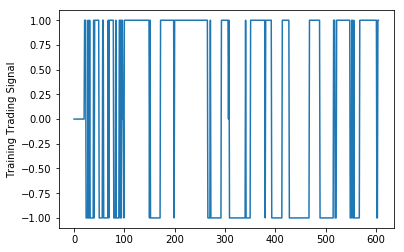

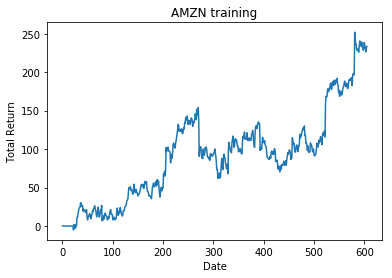

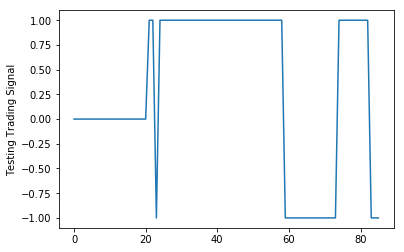

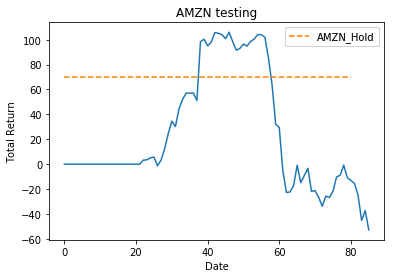

In [227]:
train_test_Model("AMZN", trainingData=amzn_trainingData, testingData=amzn_testingData,
                 length=21, step=1000, coef=0.9, speed=0.9)

Reinforcement Learning 1 th step, Sharp Ratio: 0.009977040013503365
Reinforcement Learning 2 th step, Sharp Ratio: 0.004929991258588982
Reinforcement Learning 3 th step, Sharp Ratio: 0.018333340790694864
Reinforcement Learning 4 th step, Sharp Ratio: 0.019371897789107664
Reinforcement Learning 5 th step, Sharp Ratio: 0.022968261493681995
Reinforcement Learning 6 th step, Sharp Ratio: 0.024780396403365632
Reinforcement Learning 7 th step, Sharp Ratio: 0.027141639230173212
Reinforcement Learning 8 th step, Sharp Ratio: 0.034609213437536084
Reinforcement Learning 9 th step, Sharp Ratio: 0.0356042943315765
Reinforcement Learning 10 th step, Sharp Ratio: 0.03620927773887753
Reinforcement Learning 11 th step, Sharp Ratio: 0.04412240224413456
Reinforcement Learning 12 th step, Sharp Ratio: 0.044797187627928545
Reinforcement Learning 13 th step, Sharp Ratio: 0.04636048323719288
Reinforcement Learning 14 th step, Sharp Ratio: 0.04706629142356372
Reinforcement Learning 15 th step, Sharp Ratio: 0

Reinforcement Learning 124 th step, Sharp Ratio: 0.10806521666411076
Reinforcement Learning 125 th step, Sharp Ratio: 0.1158577751510693
Reinforcement Learning 126 th step, Sharp Ratio: 0.11569744235582319
Reinforcement Learning 127 th step, Sharp Ratio: 0.10889611327668386
Reinforcement Learning 128 th step, Sharp Ratio: 0.11570122322827824
Reinforcement Learning 129 th step, Sharp Ratio: 0.12017935156645138
Reinforcement Learning 130 th step, Sharp Ratio: 0.11974068510117473
Reinforcement Learning 131 th step, Sharp Ratio: 0.12198244507621554
Reinforcement Learning 132 th step, Sharp Ratio: 0.12267911472052648
Reinforcement Learning 133 th step, Sharp Ratio: 0.12230859330336019
Reinforcement Learning 134 th step, Sharp Ratio: 0.12106764495979006
Reinforcement Learning 135 th step, Sharp Ratio: 0.12236844692153494
Reinforcement Learning 136 th step, Sharp Ratio: 0.12002850886707922
Reinforcement Learning 137 th step, Sharp Ratio: 0.1201886978442119
Reinforcement Learning 138 th step, 

Reinforcement Learning 246 th step, Sharp Ratio: 0.1176572386646484
Reinforcement Learning 247 th step, Sharp Ratio: 0.12097588793807762
Reinforcement Learning 248 th step, Sharp Ratio: 0.11768529463485912
Reinforcement Learning 249 th step, Sharp Ratio: 0.1157658468024664
Reinforcement Learning 250 th step, Sharp Ratio: 0.11427595154216091
Reinforcement Learning 251 th step, Sharp Ratio: 0.12097588793807762
Reinforcement Learning 252 th step, Sharp Ratio: 0.11625384400673516
Reinforcement Learning 253 th step, Sharp Ratio: 0.12254542525759658
Reinforcement Learning 254 th step, Sharp Ratio: 0.11390432490019478
Reinforcement Learning 255 th step, Sharp Ratio: 0.12026519519106085
Reinforcement Learning 256 th step, Sharp Ratio: 0.12701458514962358
Reinforcement Learning 257 th step, Sharp Ratio: 0.12026519519106085
Reinforcement Learning 258 th step, Sharp Ratio: 0.12195525498892343
Reinforcement Learning 259 th step, Sharp Ratio: 0.11033535773263539
Reinforcement Learning 260 th step, 

Reinforcement Learning 366 th step, Sharp Ratio: 0.14642525726502786
Reinforcement Learning 367 th step, Sharp Ratio: 0.14769390890877077
Reinforcement Learning 368 th step, Sharp Ratio: 0.1389304508198032
Reinforcement Learning 369 th step, Sharp Ratio: 0.14769390890877077
Reinforcement Learning 370 th step, Sharp Ratio: 0.14642525726502786
Reinforcement Learning 371 th step, Sharp Ratio: 0.14642525726502786
Reinforcement Learning 372 th step, Sharp Ratio: 0.14956421788422317
Reinforcement Learning 373 th step, Sharp Ratio: 0.1389304508198032
Reinforcement Learning 374 th step, Sharp Ratio: 0.14769390890877077
Reinforcement Learning 375 th step, Sharp Ratio: 0.14642525726502786
Reinforcement Learning 376 th step, Sharp Ratio: 0.14642525726502786
Reinforcement Learning 377 th step, Sharp Ratio: 0.14956421788422317
Reinforcement Learning 378 th step, Sharp Ratio: 0.1389304508198032
Reinforcement Learning 379 th step, Sharp Ratio: 0.14794496694627848
Reinforcement Learning 380 th step, S

Reinforcement Learning 490 th step, Sharp Ratio: 0.142731577751054
Reinforcement Learning 491 th step, Sharp Ratio: 0.142731577751054
Reinforcement Learning 492 th step, Sharp Ratio: 0.142731577751054
Reinforcement Learning 493 th step, Sharp Ratio: 0.142731577751054
Reinforcement Learning 494 th step, Sharp Ratio: 0.142731577751054
Reinforcement Learning 495 th step, Sharp Ratio: 0.142731577751054
Reinforcement Learning 496 th step, Sharp Ratio: 0.142731577751054
Reinforcement Learning 497 th step, Sharp Ratio: 0.142731577751054
Reinforcement Learning 498 th step, Sharp Ratio: 0.142731577751054
Reinforcement Learning 499 th step, Sharp Ratio: 0.142731577751054
Reinforcement Learning 500 th step, Sharp Ratio: 0.142731577751054
Reinforcement Learning 501 th step, Sharp Ratio: 0.142731577751054
Reinforcement Learning 502 th step, Sharp Ratio: 0.142731577751054
Reinforcement Learning 503 th step, Sharp Ratio: 0.142731577751054
Reinforcement Learning 504 th step, Sharp Ratio: 0.14308961416

Reinforcement Learning 614 th step, Sharp Ratio: 0.14658559672894864
Reinforcement Learning 615 th step, Sharp Ratio: 0.14705569874688992
Reinforcement Learning 616 th step, Sharp Ratio: 0.15128680569463832
Reinforcement Learning 617 th step, Sharp Ratio: 0.15105680251355397
Reinforcement Learning 618 th step, Sharp Ratio: 0.14705569874688992
Reinforcement Learning 619 th step, Sharp Ratio: 0.15128680569463832
Reinforcement Learning 620 th step, Sharp Ratio: 0.14776975133157125
Reinforcement Learning 621 th step, Sharp Ratio: 0.15162989975481136
Reinforcement Learning 622 th step, Sharp Ratio: 0.14813412674770632
Reinforcement Learning 623 th step, Sharp Ratio: 0.15071496954177066
Reinforcement Learning 624 th step, Sharp Ratio: 0.15162989975481136
Reinforcement Learning 625 th step, Sharp Ratio: 0.148680838019252
Reinforcement Learning 626 th step, Sharp Ratio: 0.14776975133157125
Reinforcement Learning 627 th step, Sharp Ratio: 0.15162989975481136
Reinforcement Learning 628 th step, 

Reinforcement Learning 738 th step, Sharp Ratio: 0.15353201745259973
Reinforcement Learning 739 th step, Sharp Ratio: 0.15365904414736864
Reinforcement Learning 740 th step, Sharp Ratio: 0.1545330899434685
Reinforcement Learning 741 th step, Sharp Ratio: 0.1545330899434685
Reinforcement Learning 742 th step, Sharp Ratio: 0.15375699777022528
Reinforcement Learning 743 th step, Sharp Ratio: 0.1545330899434685
Reinforcement Learning 744 th step, Sharp Ratio: 0.1521069722774305
Reinforcement Learning 745 th step, Sharp Ratio: 0.15365904414736864
Reinforcement Learning 746 th step, Sharp Ratio: 0.1545330899434685
Reinforcement Learning 747 th step, Sharp Ratio: 0.15345122496255612
Reinforcement Learning 748 th step, Sharp Ratio: 0.15302463950272288
Reinforcement Learning 749 th step, Sharp Ratio: 0.15310401818099642
Reinforcement Learning 750 th step, Sharp Ratio: 0.15302463950272288
Reinforcement Learning 751 th step, Sharp Ratio: 0.15253178878734372
Reinforcement Learning 752 th step, Sha

Reinforcement Learning 860 th step, Sharp Ratio: 0.14614754064507313
Reinforcement Learning 861 th step, Sharp Ratio: 0.15080409865842423
Reinforcement Learning 862 th step, Sharp Ratio: 0.15080409865842423
Reinforcement Learning 863 th step, Sharp Ratio: 0.15080409865842423
Reinforcement Learning 864 th step, Sharp Ratio: 0.15080409865842423
Reinforcement Learning 865 th step, Sharp Ratio: 0.1490155677878265
Reinforcement Learning 866 th step, Sharp Ratio: 0.1457703075618619
Reinforcement Learning 867 th step, Sharp Ratio: 0.14941162263470528
Reinforcement Learning 868 th step, Sharp Ratio: 0.14670399965228043
Reinforcement Learning 869 th step, Sharp Ratio: 0.14874576460600553
Reinforcement Learning 870 th step, Sharp Ratio: 0.1490155677878265
Reinforcement Learning 871 th step, Sharp Ratio: 0.15080409865842423
Reinforcement Learning 872 th step, Sharp Ratio: 0.15080409865842423
Reinforcement Learning 873 th step, Sharp Ratio: 0.15055145272142983
Reinforcement Learning 874 th step, S

Reinforcement Learning 984 th step, Sharp Ratio: 0.15802507625093637
Reinforcement Learning 985 th step, Sharp Ratio: 0.15802507625093637
Reinforcement Learning 986 th step, Sharp Ratio: 0.15802507625093637
Reinforcement Learning 987 th step, Sharp Ratio: 0.15802507625093637
Reinforcement Learning 988 th step, Sharp Ratio: 0.15191811694428314
Reinforcement Learning 989 th step, Sharp Ratio: 0.15329226538140356
Reinforcement Learning 990 th step, Sharp Ratio: 0.15442664908110879
Reinforcement Learning 991 th step, Sharp Ratio: 0.1566286643121029
Reinforcement Learning 992 th step, Sharp Ratio: 0.1566286643121029
Reinforcement Learning 993 th step, Sharp Ratio: 0.15482996377205138
Reinforcement Learning 994 th step, Sharp Ratio: 0.1569463720050245
Reinforcement Learning 995 th step, Sharp Ratio: 0.1591765040260242
Reinforcement Learning 996 th step, Sharp Ratio: 0.1591765040260242
Reinforcement Learning 997 th step, Sharp Ratio: 0.15885900363760144
Reinforcement Learning 998 th step, Sha

Reinforcement Learning 124 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 125 th step, Sharp Ratio: 0.2141658089512125
Reinforcement Learning 126 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 127 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 128 th step, Sharp Ratio: 0.2141658089512125
Reinforcement Learning 129 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 130 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 131 th step, Sharp Ratio: 0.2141658089512125
Reinforcement Learning 132 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 133 th step, Sharp Ratio: 0.2141658089512125
Reinforcement Learning 134 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 135 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 136 th step, Sharp Ratio: 0.2141658089512125
Reinforcement Learning 137 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 138 th step, Sharp Ratio:

Reinforcement Learning 249 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 250 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 251 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 252 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 253 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 254 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 255 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 256 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 257 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 258 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 259 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 260 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 261 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 262 th step, Sharp Ratio: 0.2143566686623982
Reinforcement Learning 263 th step, Sharp Ratio:

Reinforcement Learning 406 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 407 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 408 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 409 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 410 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 411 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 412 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 413 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 414 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 415 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 416 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 417 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 418 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 419 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 420 th step

Reinforcement Learning 531 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 532 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 533 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 534 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 535 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 536 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 537 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 538 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 539 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 540 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 541 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 542 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 543 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 544 th step, Sharp Ratio: 0.22733619579796657
Reinforcement Learning 545 th step

Reinforcement Learning 653 th step, Sharp Ratio: 0.26230645912417033
Reinforcement Learning 654 th step, Sharp Ratio: 0.26230645912417033
Reinforcement Learning 655 th step, Sharp Ratio: 0.26230645912417033
Reinforcement Learning 656 th step, Sharp Ratio: 0.26230645912417033
Reinforcement Learning 657 th step, Sharp Ratio: 0.26230645912417033
Reinforcement Learning 658 th step, Sharp Ratio: 0.26230645912417033
Reinforcement Learning 659 th step, Sharp Ratio: 0.2630643886358377
Reinforcement Learning 660 th step, Sharp Ratio: 0.26230645912417033
Reinforcement Learning 661 th step, Sharp Ratio: 0.26230645912417033
Reinforcement Learning 662 th step, Sharp Ratio: 0.26230645912417033
Reinforcement Learning 663 th step, Sharp Ratio: 0.26230645912417033
Reinforcement Learning 664 th step, Sharp Ratio: 0.26230645912417033
Reinforcement Learning 665 th step, Sharp Ratio: 0.26230645912417033
Reinforcement Learning 666 th step, Sharp Ratio: 0.2630643886358377
Reinforcement Learning 667 th step, 

Reinforcement Learning 813 th step, Sharp Ratio: 0.2704117095432568
Reinforcement Learning 814 th step, Sharp Ratio: 0.2704117095432568
Reinforcement Learning 815 th step, Sharp Ratio: 0.26880177119031
Reinforcement Learning 816 th step, Sharp Ratio: 0.2704117095432568
Reinforcement Learning 817 th step, Sharp Ratio: 0.2704117095432568
Reinforcement Learning 818 th step, Sharp Ratio: 0.26915579667419837
Reinforcement Learning 819 th step, Sharp Ratio: 0.2704117095432568
Reinforcement Learning 820 th step, Sharp Ratio: 0.26880177119031
Reinforcement Learning 821 th step, Sharp Ratio: 0.2704117095432568
Reinforcement Learning 822 th step, Sharp Ratio: 0.2704117095432568
Reinforcement Learning 823 th step, Sharp Ratio: 0.26915579667419837
Reinforcement Learning 824 th step, Sharp Ratio: 0.2704117095432568
Reinforcement Learning 825 th step, Sharp Ratio: 0.2700571009573102
Reinforcement Learning 826 th step, Sharp Ratio: 0.2704117095432568
Reinforcement Learning 827 th step, Sharp Ratio: 0

Reinforcement Learning 934 th step, Sharp Ratio: 0.2704117095432568
Reinforcement Learning 935 th step, Sharp Ratio: 0.2704117095432568
Reinforcement Learning 936 th step, Sharp Ratio: 0.2700571009573102
Reinforcement Learning 937 th step, Sharp Ratio: 0.2704117095432568
Reinforcement Learning 938 th step, Sharp Ratio: 0.2704117095432568
Reinforcement Learning 939 th step, Sharp Ratio: 0.2704117095432568
Reinforcement Learning 940 th step, Sharp Ratio: 0.2704117095432568
Reinforcement Learning 941 th step, Sharp Ratio: 0.2704117095432568
Reinforcement Learning 942 th step, Sharp Ratio: 0.2704117095432568
Reinforcement Learning 943 th step, Sharp Ratio: 0.2704117095432568
Reinforcement Learning 944 th step, Sharp Ratio: 0.2704117095432568
Reinforcement Learning 945 th step, Sharp Ratio: 0.2700571009573102
Reinforcement Learning 946 th step, Sharp Ratio: 0.2704117095432568
Reinforcement Learning 947 th step, Sharp Ratio: 0.2704117095432568
Reinforcement Learning 948 th step, Sharp Ratio:

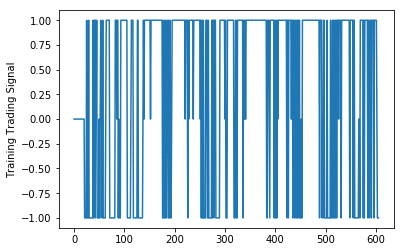

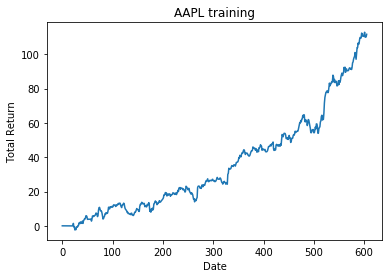

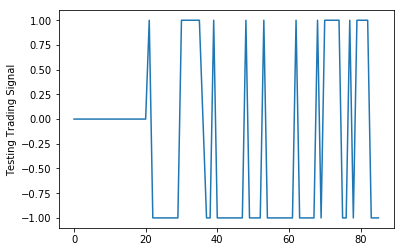

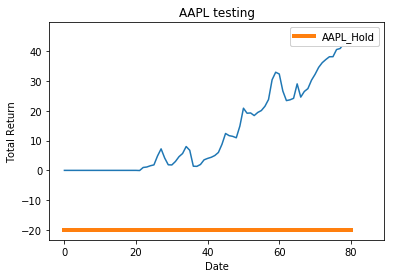

In [228]:
train_test_Model("AAPL", trainingData=aapl_trainingData, testingData=aapl_testingData,
                 length=21, step=1000, coef=0.9, speed=0.9)

Reinforcement Learning 1 th step, Sharp Ratio: 0.0002517881173950318
Reinforcement Learning 2 th step, Sharp Ratio: 0.0033482346829056394
Reinforcement Learning 3 th step, Sharp Ratio: 0.001816248436920395
Reinforcement Learning 4 th step, Sharp Ratio: 0.011804305693912429
Reinforcement Learning 5 th step, Sharp Ratio: 0.0214527500986156
Reinforcement Learning 6 th step, Sharp Ratio: 0.02896260284755773
Reinforcement Learning 7 th step, Sharp Ratio: 0.028609359226139587
Reinforcement Learning 8 th step, Sharp Ratio: 0.02802494444989703
Reinforcement Learning 9 th step, Sharp Ratio: 0.03076713806593246
Reinforcement Learning 10 th step, Sharp Ratio: 0.03164205496039725
Reinforcement Learning 11 th step, Sharp Ratio: 0.042915341137632526
Reinforcement Learning 12 th step, Sharp Ratio: 0.043285854582391994
Reinforcement Learning 13 th step, Sharp Ratio: 0.04183539675934338
Reinforcement Learning 14 th step, Sharp Ratio: 0.045212254563126435
Reinforcement Learning 15 th step, Sharp Ratio: 

Reinforcement Learning 124 th step, Sharp Ratio: 0.15151707855090024
Reinforcement Learning 125 th step, Sharp Ratio: 0.15151707855090024
Reinforcement Learning 126 th step, Sharp Ratio: 0.15350771517745349
Reinforcement Learning 127 th step, Sharp Ratio: 0.15350771517745349
Reinforcement Learning 128 th step, Sharp Ratio: 0.15334342637995213
Reinforcement Learning 129 th step, Sharp Ratio: 0.15012605633501966
Reinforcement Learning 130 th step, Sharp Ratio: 0.14763377297281882
Reinforcement Learning 131 th step, Sharp Ratio: 0.14904629265982436
Reinforcement Learning 132 th step, Sharp Ratio: 0.14925489203384262
Reinforcement Learning 133 th step, Sharp Ratio: 0.15245524600101215
Reinforcement Learning 134 th step, Sharp Ratio: 0.1551072861624478
Reinforcement Learning 135 th step, Sharp Ratio: 0.1574846903543857
Reinforcement Learning 136 th step, Sharp Ratio: 0.15665400253580652
Reinforcement Learning 137 th step, Sharp Ratio: 0.15577345430799003
Reinforcement Learning 138 th step, 

Reinforcement Learning 246 th step, Sharp Ratio: 0.1616599510773747
Reinforcement Learning 247 th step, Sharp Ratio: 0.1616599510773747
Reinforcement Learning 248 th step, Sharp Ratio: 0.1616599510773747
Reinforcement Learning 249 th step, Sharp Ratio: 0.1616599510773747
Reinforcement Learning 250 th step, Sharp Ratio: 0.1616599510773747
Reinforcement Learning 251 th step, Sharp Ratio: 0.1620500493803243
Reinforcement Learning 252 th step, Sharp Ratio: 0.1620500493803243
Reinforcement Learning 253 th step, Sharp Ratio: 0.1620500493803243
Reinforcement Learning 254 th step, Sharp Ratio: 0.1620500493803243
Reinforcement Learning 255 th step, Sharp Ratio: 0.1620500493803243
Reinforcement Learning 256 th step, Sharp Ratio: 0.1620500493803243
Reinforcement Learning 257 th step, Sharp Ratio: 0.1620500493803243
Reinforcement Learning 258 th step, Sharp Ratio: 0.16120510078798928
Reinforcement Learning 259 th step, Sharp Ratio: 0.16271785614777945
Reinforcement Learning 260 th step, Sharp Rati

Reinforcement Learning 371 th step, Sharp Ratio: 0.17145270421291176
Reinforcement Learning 372 th step, Sharp Ratio: 0.17145270421291176
Reinforcement Learning 373 th step, Sharp Ratio: 0.17145270421291176
Reinforcement Learning 374 th step, Sharp Ratio: 0.17145270421291176
Reinforcement Learning 375 th step, Sharp Ratio: 0.17145270421291176
Reinforcement Learning 376 th step, Sharp Ratio: 0.17145270421291176
Reinforcement Learning 377 th step, Sharp Ratio: 0.172204894378411
Reinforcement Learning 378 th step, Sharp Ratio: 0.1725787748179226
Reinforcement Learning 379 th step, Sharp Ratio: 0.1725787748179226
Reinforcement Learning 380 th step, Sharp Ratio: 0.1725787748179226
Reinforcement Learning 381 th step, Sharp Ratio: 0.17357522051521956
Reinforcement Learning 382 th step, Sharp Ratio: 0.17357522051521956
Reinforcement Learning 383 th step, Sharp Ratio: 0.17357522051521956
Reinforcement Learning 384 th step, Sharp Ratio: 0.17357522051521956
Reinforcement Learning 385 th step, Sha

Reinforcement Learning 492 th step, Sharp Ratio: 0.1868136517952542
Reinforcement Learning 493 th step, Sharp Ratio: 0.18908891257115468
Reinforcement Learning 494 th step, Sharp Ratio: 0.18908891257115468
Reinforcement Learning 495 th step, Sharp Ratio: 0.1868136517952542
Reinforcement Learning 496 th step, Sharp Ratio: 0.18908891257115468
Reinforcement Learning 497 th step, Sharp Ratio: 0.18908891257115468
Reinforcement Learning 498 th step, Sharp Ratio: 0.1868136517952542
Reinforcement Learning 499 th step, Sharp Ratio: 0.18908891257115468
Reinforcement Learning 500 th step, Sharp Ratio: 0.18908891257115468
Reinforcement Learning 501 th step, Sharp Ratio: 0.1868136517952542
Reinforcement Learning 502 th step, Sharp Ratio: 0.1904222289909037
Reinforcement Learning 503 th step, Sharp Ratio: 0.18908891257115468
Reinforcement Learning 504 th step, Sharp Ratio: 0.1904222289909037
Reinforcement Learning 505 th step, Sharp Ratio: 0.1868136517952542
Reinforcement Learning 506 th step, Sharp

Reinforcement Learning 616 th step, Sharp Ratio: 0.18710555583763058
Reinforcement Learning 617 th step, Sharp Ratio: 0.1849439918822234
Reinforcement Learning 618 th step, Sharp Ratio: 0.18710555583763058
Reinforcement Learning 619 th step, Sharp Ratio: 0.1849439918822234
Reinforcement Learning 620 th step, Sharp Ratio: 0.18710555583763058
Reinforcement Learning 621 th step, Sharp Ratio: 0.18676395400241708
Reinforcement Learning 622 th step, Sharp Ratio: 0.18809258866253234
Reinforcement Learning 623 th step, Sharp Ratio: 0.1857763624472751
Reinforcement Learning 624 th step, Sharp Ratio: 0.18809258866253234
Reinforcement Learning 625 th step, Sharp Ratio: 0.1857763624472751
Reinforcement Learning 626 th step, Sharp Ratio: 0.18809258866253234
Reinforcement Learning 627 th step, Sharp Ratio: 0.1857763624472751
Reinforcement Learning 628 th step, Sharp Ratio: 0.18809258866253234
Reinforcement Learning 629 th step, Sharp Ratio: 0.1857763624472751
Reinforcement Learning 630 th step, Shar

Reinforcement Learning 739 th step, Sharp Ratio: 0.19729937909786296
Reinforcement Learning 740 th step, Sharp Ratio: 0.19632187960400985
Reinforcement Learning 741 th step, Sharp Ratio: 0.19632187960400985
Reinforcement Learning 742 th step, Sharp Ratio: 0.19729937909786296
Reinforcement Learning 743 th step, Sharp Ratio: 0.19632187960400985
Reinforcement Learning 744 th step, Sharp Ratio: 0.19632187960400985
Reinforcement Learning 745 th step, Sharp Ratio: 0.198624120032685
Reinforcement Learning 746 th step, Sharp Ratio: 0.1949967775282005
Reinforcement Learning 747 th step, Sharp Ratio: 0.19632187960400985
Reinforcement Learning 748 th step, Sharp Ratio: 0.198624120032685
Reinforcement Learning 749 th step, Sharp Ratio: 0.19632187960400985
Reinforcement Learning 750 th step, Sharp Ratio: 0.19729937909786296
Reinforcement Learning 751 th step, Sharp Ratio: 0.19632187960400985
Reinforcement Learning 752 th step, Sharp Ratio: 0.19632187960400985
Reinforcement Learning 753 th step, Sha

Reinforcement Learning 862 th step, Sharp Ratio: 0.19793053665277072
Reinforcement Learning 863 th step, Sharp Ratio: 0.1969959559137645
Reinforcement Learning 864 th step, Sharp Ratio: 0.198320405416659
Reinforcement Learning 865 th step, Sharp Ratio: 0.198320405416659
Reinforcement Learning 866 th step, Sharp Ratio: 0.1969959559137645
Reinforcement Learning 867 th step, Sharp Ratio: 0.19753001840779183
Reinforcement Learning 868 th step, Sharp Ratio: 0.1965952626091661
Reinforcement Learning 869 th step, Sharp Ratio: 0.19791976743911086
Reinforcement Learning 870 th step, Sharp Ratio: 0.19791976743911086
Reinforcement Learning 871 th step, Sharp Ratio: 0.19791976743911086
Reinforcement Learning 872 th step, Sharp Ratio: 0.19573940451725216
Reinforcement Learning 873 th step, Sharp Ratio: 0.1975442869631606
Reinforcement Learning 874 th step, Sharp Ratio: 0.19801230233575415
Reinforcement Learning 875 th step, Sharp Ratio: 0.1975442869631606
Reinforcement Learning 876 th step, Sharp R

Reinforcement Learning 982 th step, Sharp Ratio: 0.20099362890387085
Reinforcement Learning 983 th step, Sharp Ratio: 0.19967078996034499
Reinforcement Learning 984 th step, Sharp Ratio: 0.19967078996034499
Reinforcement Learning 985 th step, Sharp Ratio: 0.2009549959683236
Reinforcement Learning 986 th step, Sharp Ratio: 0.1984766759236395
Reinforcement Learning 987 th step, Sharp Ratio: 0.20004427211281986
Reinforcement Learning 988 th step, Sharp Ratio: 0.19963088234677343
Reinforcement Learning 989 th step, Sharp Ratio: 0.19979934986863687
Reinforcement Learning 990 th step, Sharp Ratio: 0.1984354289924426
Reinforcement Learning 991 th step, Sharp Ratio: 0.19979934986863687
Reinforcement Learning 992 th step, Sharp Ratio: 0.1984766759236395
Reinforcement Learning 993 th step, Sharp Ratio: 0.1984354289924426
Reinforcement Learning 994 th step, Sharp Ratio: 0.19979934986863687
Reinforcement Learning 995 th step, Sharp Ratio: 0.1984766759236395
Reinforcement Learning 996 th step, Shar

Reinforcement Learning 129 th step, Sharp Ratio: 0.259794943742995
Reinforcement Learning 130 th step, Sharp Ratio: 0.2590318944553821
Reinforcement Learning 131 th step, Sharp Ratio: 0.259794943742995
Reinforcement Learning 132 th step, Sharp Ratio: 0.259794943742995
Reinforcement Learning 133 th step, Sharp Ratio: 0.259794943742995
Reinforcement Learning 134 th step, Sharp Ratio: 0.2590318944553821
Reinforcement Learning 135 th step, Sharp Ratio: 0.259794943742995
Reinforcement Learning 136 th step, Sharp Ratio: 0.259794943742995
Reinforcement Learning 137 th step, Sharp Ratio: 0.259794943742995
Reinforcement Learning 138 th step, Sharp Ratio: 0.259794943742995
Reinforcement Learning 139 th step, Sharp Ratio: 0.259794943742995
Reinforcement Learning 140 th step, Sharp Ratio: 0.2590318944553821
Reinforcement Learning 141 th step, Sharp Ratio: 0.259794943742995
Reinforcement Learning 142 th step, Sharp Ratio: 0.259794943742995
Reinforcement Learning 143 th step, Sharp Ratio: 0.25979494

Reinforcement Learning 284 th step, Sharp Ratio: 0.26571771957406887
Reinforcement Learning 285 th step, Sharp Ratio: 0.26895784883288176
Reinforcement Learning 286 th step, Sharp Ratio: 0.2658776212950369
Reinforcement Learning 287 th step, Sharp Ratio: 0.26895784883288176
Reinforcement Learning 288 th step, Sharp Ratio: 0.2691158149710802
Reinforcement Learning 289 th step, Sharp Ratio: 0.2658776212950369
Reinforcement Learning 290 th step, Sharp Ratio: 0.26895784883288176
Reinforcement Learning 291 th step, Sharp Ratio: 0.26895784883288176
Reinforcement Learning 292 th step, Sharp Ratio: 0.2658776212950369
Reinforcement Learning 293 th step, Sharp Ratio: 0.26895784883288176
Reinforcement Learning 294 th step, Sharp Ratio: 0.2691158149710802
Reinforcement Learning 295 th step, Sharp Ratio: 0.26895784883288176
Reinforcement Learning 296 th step, Sharp Ratio: 0.2658776212950369
Reinforcement Learning 297 th step, Sharp Ratio: 0.26895784883288176
Reinforcement Learning 298 th step, Shar

Reinforcement Learning 439 th step, Sharp Ratio: 0.2691158149710802
Reinforcement Learning 440 th step, Sharp Ratio: 0.2691158149710802
Reinforcement Learning 441 th step, Sharp Ratio: 0.2691158149710802
Reinforcement Learning 442 th step, Sharp Ratio: 0.2691158149710802
Reinforcement Learning 443 th step, Sharp Ratio: 0.2691158149710802
Reinforcement Learning 444 th step, Sharp Ratio: 0.2697180177995136
Reinforcement Learning 445 th step, Sharp Ratio: 0.2691158149710802
Reinforcement Learning 446 th step, Sharp Ratio: 0.2691158149710802
Reinforcement Learning 447 th step, Sharp Ratio: 0.2691158149710802
Reinforcement Learning 448 th step, Sharp Ratio: 0.2691158149710802
Reinforcement Learning 449 th step, Sharp Ratio: 0.2691158149710802
Reinforcement Learning 450 th step, Sharp Ratio: 0.2697180177995136
Reinforcement Learning 451 th step, Sharp Ratio: 0.2691158149710802
Reinforcement Learning 452 th step, Sharp Ratio: 0.2691158149710802
Reinforcement Learning 453 th step, Sharp Ratio:

Reinforcement Learning 560 th step, Sharp Ratio: 0.2698755333143803
Reinforcement Learning 561 th step, Sharp Ratio: 0.2698755333143803
Reinforcement Learning 562 th step, Sharp Ratio: 0.2691158149710802
Reinforcement Learning 563 th step, Sharp Ratio: 0.2698755333143803
Reinforcement Learning 564 th step, Sharp Ratio: 0.2691158149710802
Reinforcement Learning 565 th step, Sharp Ratio: 0.2697180177995136
Reinforcement Learning 566 th step, Sharp Ratio: 0.2691158149710802
Reinforcement Learning 567 th step, Sharp Ratio: 0.2698755333143803
Reinforcement Learning 568 th step, Sharp Ratio: 0.2698755333143803
Reinforcement Learning 569 th step, Sharp Ratio: 0.2691158149710802
Reinforcement Learning 570 th step, Sharp Ratio: 0.2697180177995136
Reinforcement Learning 571 th step, Sharp Ratio: 0.2691158149710802
Reinforcement Learning 572 th step, Sharp Ratio: 0.2698755333143803
Reinforcement Learning 573 th step, Sharp Ratio: 0.2698755333143803
Reinforcement Learning 574 th step, Sharp Ratio:

Reinforcement Learning 719 th step, Sharp Ratio: 0.26946998938178596
Reinforcement Learning 720 th step, Sharp Ratio: 0.2698755333143803
Reinforcement Learning 721 th step, Sharp Ratio: 0.27022995627705576
Reinforcement Learning 722 th step, Sharp Ratio: 0.2697180177995136
Reinforcement Learning 723 th step, Sharp Ratio: 0.27022995627705576
Reinforcement Learning 724 th step, Sharp Ratio: 0.2698755333143803
Reinforcement Learning 725 th step, Sharp Ratio: 0.2698755333143803
Reinforcement Learning 726 th step, Sharp Ratio: 0.27022995627705576
Reinforcement Learning 727 th step, Sharp Ratio: 0.2698755333143803
Reinforcement Learning 728 th step, Sharp Ratio: 0.27022995627705576
Reinforcement Learning 729 th step, Sharp Ratio: 0.2698755333143803
Reinforcement Learning 730 th step, Sharp Ratio: 0.27022995627705576
Reinforcement Learning 731 th step, Sharp Ratio: 0.2698755333143803
Reinforcement Learning 732 th step, Sharp Ratio: 0.27022995627705576
Reinforcement Learning 733 th step, Sharp

Reinforcement Learning 876 th step, Sharp Ratio: 0.27022995627705576
Reinforcement Learning 877 th step, Sharp Ratio: 0.2698755333143803
Reinforcement Learning 878 th step, Sharp Ratio: 0.27022995627705576
Reinforcement Learning 879 th step, Sharp Ratio: 0.2698755333143803
Reinforcement Learning 880 th step, Sharp Ratio: 0.27022995627705576
Reinforcement Learning 881 th step, Sharp Ratio: 0.27022995627705576
Reinforcement Learning 882 th step, Sharp Ratio: 0.2698755333143803
Reinforcement Learning 883 th step, Sharp Ratio: 0.27022995627705576
Reinforcement Learning 884 th step, Sharp Ratio: 0.2698755333143803
Reinforcement Learning 885 th step, Sharp Ratio: 0.27007266032760824
Reinforcement Learning 886 th step, Sharp Ratio: 0.27022995627705576
Reinforcement Learning 887 th step, Sharp Ratio: 0.2698755333143803
Reinforcement Learning 888 th step, Sharp Ratio: 0.27022995627705576
Reinforcement Learning 889 th step, Sharp Ratio: 0.27022995627705576
Reinforcement Learning 890 th step, Sha

Reinforcement Learning 997 th step, Sharp Ratio: 0.27022995627705576
Reinforcement Learning 998 th step, Sharp Ratio: 0.2698755333143803
Reinforcement Learning 999 th step, Sharp Ratio: 0.27022995627705576
Reinforcement Learning 1000 th step, Sharp Ratio: 0.27022995627705576


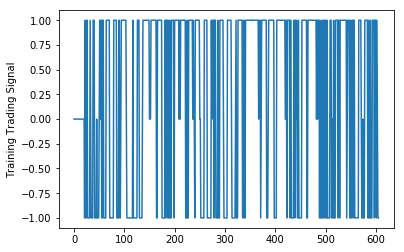

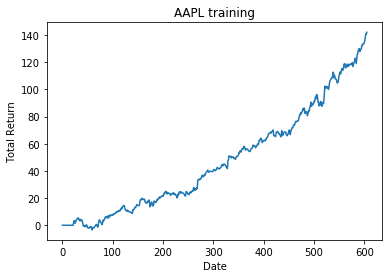

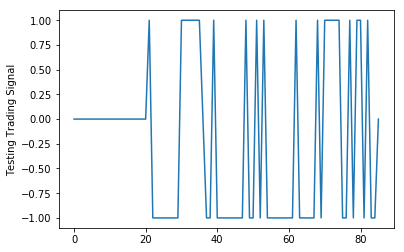

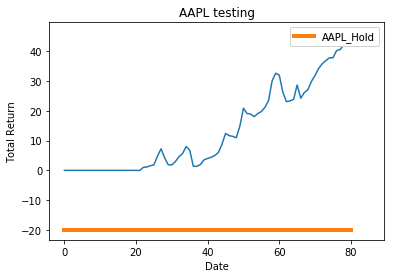

In [229]:
train_test_Model("AAPL", trainingData=aapl_trainingData, testingData=aapl_testingData,
                 length=21, step=1000, coef=0.5, speed=0.5)

Reinforcement Learning 1 th step, Sharp Ratio: 0.027334230626465828
Reinforcement Learning 2 th step, Sharp Ratio: 0.0008046600785641267
Reinforcement Learning 3 th step, Sharp Ratio: 0.015317538547492904
Reinforcement Learning 4 th step, Sharp Ratio: 0.06219610158448565
Reinforcement Learning 5 th step, Sharp Ratio: 0.077355576893834
Reinforcement Learning 6 th step, Sharp Ratio: 0.06700342992950793
Reinforcement Learning 7 th step, Sharp Ratio: 0.07651543973408827
Reinforcement Learning 8 th step, Sharp Ratio: 0.09682560612311229
Reinforcement Learning 9 th step, Sharp Ratio: 0.10554263460458715
Reinforcement Learning 10 th step, Sharp Ratio: 0.10329309862116759
Reinforcement Learning 11 th step, Sharp Ratio: 0.12913429601253434
Reinforcement Learning 12 th step, Sharp Ratio: 0.14514043227112713
Reinforcement Learning 13 th step, Sharp Ratio: 0.12230787455478213
Reinforcement Learning 14 th step, Sharp Ratio: 0.12826972465423023
Reinforcement Learning 15 th step, Sharp Ratio: 0.14112

Reinforcement Learning 124 th step, Sharp Ratio: 0.16832288039380414
Reinforcement Learning 125 th step, Sharp Ratio: 0.16832288039380414
Reinforcement Learning 126 th step, Sharp Ratio: 0.16687991197804683
Reinforcement Learning 127 th step, Sharp Ratio: 0.16448956929217243
Reinforcement Learning 128 th step, Sharp Ratio: 0.16448956929217243
Reinforcement Learning 129 th step, Sharp Ratio: 0.16448956929217243
Reinforcement Learning 130 th step, Sharp Ratio: 0.16448956929217243
Reinforcement Learning 131 th step, Sharp Ratio: 0.16448956929217243
Reinforcement Learning 132 th step, Sharp Ratio: 0.16464732402599908
Reinforcement Learning 133 th step, Sharp Ratio: 0.16555344385959733
Reinforcement Learning 134 th step, Sharp Ratio: 0.16573343016233547
Reinforcement Learning 135 th step, Sharp Ratio: 0.16573343016233547
Reinforcement Learning 136 th step, Sharp Ratio: 0.16573343016233547
Reinforcement Learning 137 th step, Sharp Ratio: 0.16573343016233547
Reinforcement Learning 138 th step

Reinforcement Learning 248 th step, Sharp Ratio: 0.19634345061412528
Reinforcement Learning 249 th step, Sharp Ratio: 0.19634345061412528
Reinforcement Learning 250 th step, Sharp Ratio: 0.19947215300248763
Reinforcement Learning 251 th step, Sharp Ratio: 0.19502061455326117
Reinforcement Learning 252 th step, Sharp Ratio: 0.19502061455326117
Reinforcement Learning 253 th step, Sharp Ratio: 0.20147331786636916
Reinforcement Learning 254 th step, Sharp Ratio: 0.20456624252077107
Reinforcement Learning 255 th step, Sharp Ratio: 0.20147331786636916
Reinforcement Learning 256 th step, Sharp Ratio: 0.20147331786636916
Reinforcement Learning 257 th step, Sharp Ratio: 0.20147331786636916
Reinforcement Learning 258 th step, Sharp Ratio: 0.20456624252077107
Reinforcement Learning 259 th step, Sharp Ratio: 0.20147331786636916
Reinforcement Learning 260 th step, Sharp Ratio: 0.20147331786636916
Reinforcement Learning 261 th step, Sharp Ratio: 0.19681791027098144
Reinforcement Learning 262 th step

Reinforcement Learning 371 th step, Sharp Ratio: 0.21140445662165697
Reinforcement Learning 372 th step, Sharp Ratio: 0.20550088619197024
Reinforcement Learning 373 th step, Sharp Ratio: 0.20458796322086817
Reinforcement Learning 374 th step, Sharp Ratio: 0.20772114624489232
Reinforcement Learning 375 th step, Sharp Ratio: 0.2102501426894185
Reinforcement Learning 376 th step, Sharp Ratio: 0.21297253522025736
Reinforcement Learning 377 th step, Sharp Ratio: 0.20531590753166543
Reinforcement Learning 378 th step, Sharp Ratio: 0.2084404921802937
Reinforcement Learning 379 th step, Sharp Ratio: 0.20841854985569302
Reinforcement Learning 380 th step, Sharp Ratio: 0.20632441457450365
Reinforcement Learning 381 th step, Sharp Ratio: 0.20769673544113615
Reinforcement Learning 382 th step, Sharp Ratio: 0.2102501426894185
Reinforcement Learning 383 th step, Sharp Ratio: 0.20712688911473992
Reinforcement Learning 384 th step, Sharp Ratio: 0.21230974932368304
Reinforcement Learning 385 th step, S

Reinforcement Learning 495 th step, Sharp Ratio: 0.220801756397243
Reinforcement Learning 496 th step, Sharp Ratio: 0.22517217292131386
Reinforcement Learning 497 th step, Sharp Ratio: 0.220801756397243
Reinforcement Learning 498 th step, Sharp Ratio: 0.2212906377442951
Reinforcement Learning 499 th step, Sharp Ratio: 0.22347424909347188
Reinforcement Learning 500 th step, Sharp Ratio: 0.220801756397243
Reinforcement Learning 501 th step, Sharp Ratio: 0.2242936672528629
Reinforcement Learning 502 th step, Sharp Ratio: 0.22739973547127595
Reinforcement Learning 503 th step, Sharp Ratio: 0.21794758688640453
Reinforcement Learning 504 th step, Sharp Ratio: 0.22128249670076977
Reinforcement Learning 505 th step, Sharp Ratio: 0.2194285713559795
Reinforcement Learning 506 th step, Sharp Ratio: 0.2204016779987213
Reinforcement Learning 507 th step, Sharp Ratio: 0.21199446870691266
Reinforcement Learning 508 th step, Sharp Ratio: 0.2204016779987213
Reinforcement Learning 509 th step, Sharp Rat

Reinforcement Learning 615 th step, Sharp Ratio: 0.21658029481159138
Reinforcement Learning 616 th step, Sharp Ratio: 0.21734319300639937
Reinforcement Learning 617 th step, Sharp Ratio: 0.217229929819207
Reinforcement Learning 618 th step, Sharp Ratio: 0.21732694097843994
Reinforcement Learning 619 th step, Sharp Ratio: 0.21413575543723354
Reinforcement Learning 620 th step, Sharp Ratio: 0.21413575543723354
Reinforcement Learning 621 th step, Sharp Ratio: 0.21816085289063483
Reinforcement Learning 622 th step, Sharp Ratio: 0.21732694097843994
Reinforcement Learning 623 th step, Sharp Ratio: 0.21508305317707535
Reinforcement Learning 624 th step, Sharp Ratio: 0.21508305317707535
Reinforcement Learning 625 th step, Sharp Ratio: 0.21700721968366268
Reinforcement Learning 626 th step, Sharp Ratio: 0.21815338690366548
Reinforcement Learning 627 th step, Sharp Ratio: 0.21495641454635997
Reinforcement Learning 628 th step, Sharp Ratio: 0.21415600375731533
Reinforcement Learning 629 th step, 

Reinforcement Learning 736 th step, Sharp Ratio: 0.21878105361523562
Reinforcement Learning 737 th step, Sharp Ratio: 0.2228797629950458
Reinforcement Learning 738 th step, Sharp Ratio: 0.21555790478404283
Reinforcement Learning 739 th step, Sharp Ratio: 0.22093734398042258
Reinforcement Learning 740 th step, Sharp Ratio: 0.21361744557376422
Reinforcement Learning 741 th step, Sharp Ratio: 0.21997651891195663
Reinforcement Learning 742 th step, Sharp Ratio: 0.21684255095234137
Reinforcement Learning 743 th step, Sharp Ratio: 0.21556238310131293
Reinforcement Learning 744 th step, Sharp Ratio: 0.21997651891195663
Reinforcement Learning 745 th step, Sharp Ratio: 0.21361744557376422
Reinforcement Learning 746 th step, Sharp Ratio: 0.21997651891195663
Reinforcement Learning 747 th step, Sharp Ratio: 0.21361744557376422
Reinforcement Learning 748 th step, Sharp Ratio: 0.21997651891195663
Reinforcement Learning 749 th step, Sharp Ratio: 0.21305910715237938
Reinforcement Learning 750 th step,

Reinforcement Learning 860 th step, Sharp Ratio: 0.2152312460289797
Reinforcement Learning 861 th step, Sharp Ratio: 0.21717249174139375
Reinforcement Learning 862 th step, Sharp Ratio: 0.2263861313717699
Reinforcement Learning 863 th step, Sharp Ratio: 0.2231741607607782
Reinforcement Learning 864 th step, Sharp Ratio: 0.22631014928558418
Reinforcement Learning 865 th step, Sharp Ratio: 0.2212502224706142
Reinforcement Learning 866 th step, Sharp Ratio: 0.22631014928558418
Reinforcement Learning 867 th step, Sharp Ratio: 0.21972869343421786
Reinforcement Learning 868 th step, Sharp Ratio: 0.21846388538139674
Reinforcement Learning 869 th step, Sharp Ratio: 0.22631014928558418
Reinforcement Learning 870 th step, Sharp Ratio: 0.22637099306247332
Reinforcement Learning 871 th step, Sharp Ratio: 0.2242679463932622
Reinforcement Learning 872 th step, Sharp Ratio: 0.21717249174139375
Reinforcement Learning 873 th step, Sharp Ratio: 0.21717249174139375
Reinforcement Learning 874 th step, Sha

Reinforcement Learning 983 th step, Sharp Ratio: 0.2265672946428952
Reinforcement Learning 984 th step, Sharp Ratio: 0.23168204821245475
Reinforcement Learning 985 th step, Sharp Ratio: 0.22996804927486617
Reinforcement Learning 986 th step, Sharp Ratio: 0.23168204821245475
Reinforcement Learning 987 th step, Sharp Ratio: 0.22864708160276961
Reinforcement Learning 988 th step, Sharp Ratio: 0.22323454951893412
Reinforcement Learning 989 th step, Sharp Ratio: 0.22588990485266996
Reinforcement Learning 990 th step, Sharp Ratio: 0.22588990485266996
Reinforcement Learning 991 th step, Sharp Ratio: 0.22868750663862772
Reinforcement Learning 992 th step, Sharp Ratio: 0.23168204821245475
Reinforcement Learning 993 th step, Sharp Ratio: 0.2265672946428952
Reinforcement Learning 994 th step, Sharp Ratio: 0.23509291546236366
Reinforcement Learning 995 th step, Sharp Ratio: 0.2265672946428952
Reinforcement Learning 996 th step, Sharp Ratio: 0.22466597419380915
Reinforcement Learning 997 th step, S

Reinforcement Learning 141 th step, Sharp Ratio: 0.4519142104322605
Reinforcement Learning 142 th step, Sharp Ratio: 0.4519142104322605
Reinforcement Learning 143 th step, Sharp Ratio: 0.4519142104322605
Reinforcement Learning 144 th step, Sharp Ratio: 0.4519142104322605
Reinforcement Learning 145 th step, Sharp Ratio: 0.4519142104322605
Reinforcement Learning 146 th step, Sharp Ratio: 0.4519142104322605
Reinforcement Learning 147 th step, Sharp Ratio: 0.4519142104322605
Reinforcement Learning 148 th step, Sharp Ratio: 0.4519142104322605
Reinforcement Learning 149 th step, Sharp Ratio: 0.4519142104322605
Reinforcement Learning 150 th step, Sharp Ratio: 0.4519142104322605
Reinforcement Learning 151 th step, Sharp Ratio: 0.4519142104322605
Reinforcement Learning 152 th step, Sharp Ratio: 0.4519142104322605
Reinforcement Learning 153 th step, Sharp Ratio: 0.4519142104322605
Reinforcement Learning 154 th step, Sharp Ratio: 0.4519142104322605
Reinforcement Learning 155 th step, Sharp Ratio:

Reinforcement Learning 299 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 300 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 301 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 302 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 303 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 304 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 305 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 306 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 307 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 308 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 309 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 310 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 311 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 312 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 313 th step

Reinforcement Learning 419 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 420 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 421 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 422 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 423 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 424 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 425 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 426 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 427 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 428 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 429 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 430 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 431 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 432 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 433 th step

Reinforcement Learning 538 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 539 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 540 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 541 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 542 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 543 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 544 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 545 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 546 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 547 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 548 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 549 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 550 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 551 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 552 th step,

Reinforcement Learning 694 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 695 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 696 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 697 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 698 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 699 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 700 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 701 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 702 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 703 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 704 th step, Sharp Ratio: 0.45872361516247295
Reinforcement Learning 705 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 706 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 707 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 708 th step, Sharp Rat

Reinforcement Learning 817 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 818 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 819 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 820 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 821 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 822 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 823 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 824 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 825 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 826 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 827 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 828 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 829 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 830 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 831 th step, Sharp Ratio:

Reinforcement Learning 977 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 978 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 979 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 980 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 981 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 982 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 983 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 984 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 985 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 986 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 987 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 988 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 989 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 990 th step, Sharp Ratio: 0.4596117535403465
Reinforcement Learning 991 th step, Sharp Ratio:

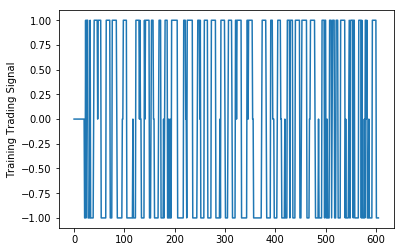

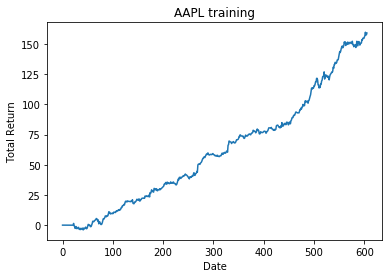

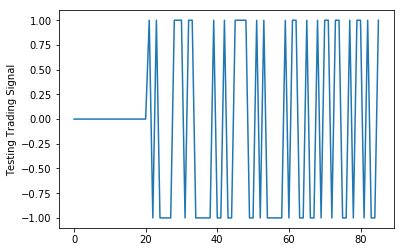

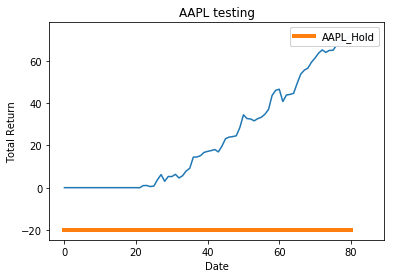

In [230]:
train_test_Model("AAPL", trainingData=aapl_trainingData, testingData=aapl_testingData,
                 length=21, step=1000, coef=0.1, speed=0.3)

Reinforcement Learning 1 th step, Sharp Ratio: 0.01670921863984707
Reinforcement Learning 2 th step, Sharp Ratio: 0.0937486473159626
Reinforcement Learning 3 th step, Sharp Ratio: 0.08308940337930626
Reinforcement Learning 4 th step, Sharp Ratio: 0.09480654923317
Reinforcement Learning 5 th step, Sharp Ratio: 0.10720993396543961
Reinforcement Learning 6 th step, Sharp Ratio: 0.11362984374959544
Reinforcement Learning 7 th step, Sharp Ratio: 0.11995582952174388
Reinforcement Learning 8 th step, Sharp Ratio: 0.12886821269326262
Reinforcement Learning 9 th step, Sharp Ratio: 0.13336449088700125
Reinforcement Learning 10 th step, Sharp Ratio: 0.12008603465065844
Reinforcement Learning 11 th step, Sharp Ratio: 0.11517640982509195
Reinforcement Learning 12 th step, Sharp Ratio: 0.11635698401528628
Reinforcement Learning 13 th step, Sharp Ratio: 0.11725831958508896
Reinforcement Learning 14 th step, Sharp Ratio: 0.1129688820983384
Reinforcement Learning 15 th step, Sharp Ratio: 0.115012557686

Reinforcement Learning 126 th step, Sharp Ratio: 0.1436191798717707
Reinforcement Learning 127 th step, Sharp Ratio: 0.1436191798717707
Reinforcement Learning 128 th step, Sharp Ratio: 0.1422902927866252
Reinforcement Learning 129 th step, Sharp Ratio: 0.14406616022629476
Reinforcement Learning 130 th step, Sharp Ratio: 0.14406616022629476
Reinforcement Learning 131 th step, Sharp Ratio: 0.14406616022629476
Reinforcement Learning 132 th step, Sharp Ratio: 0.14406616022629476
Reinforcement Learning 133 th step, Sharp Ratio: 0.14406616022629476
Reinforcement Learning 134 th step, Sharp Ratio: 0.14519338535691503
Reinforcement Learning 135 th step, Sharp Ratio: 0.14448198497175574
Reinforcement Learning 136 th step, Sharp Ratio: 0.14448198497175574
Reinforcement Learning 137 th step, Sharp Ratio: 0.14448198497175574
Reinforcement Learning 138 th step, Sharp Ratio: 0.14448198497175574
Reinforcement Learning 139 th step, Sharp Ratio: 0.14448198497175574
Reinforcement Learning 140 th step, S

Reinforcement Learning 247 th step, Sharp Ratio: 0.14524740015703402
Reinforcement Learning 248 th step, Sharp Ratio: 0.14524740015703402
Reinforcement Learning 249 th step, Sharp Ratio: 0.14524740015703402
Reinforcement Learning 250 th step, Sharp Ratio: 0.147289819221555
Reinforcement Learning 251 th step, Sharp Ratio: 0.147289819221555
Reinforcement Learning 252 th step, Sharp Ratio: 0.147289819221555
Reinforcement Learning 253 th step, Sharp Ratio: 0.14866732978373773
Reinforcement Learning 254 th step, Sharp Ratio: 0.15007973914218625
Reinforcement Learning 255 th step, Sharp Ratio: 0.14967436306217807
Reinforcement Learning 256 th step, Sharp Ratio: 0.14967436306217807
Reinforcement Learning 257 th step, Sharp Ratio: 0.14967436306217807
Reinforcement Learning 258 th step, Sharp Ratio: 0.14967436306217807
Reinforcement Learning 259 th step, Sharp Ratio: 0.14967436306217807
Reinforcement Learning 260 th step, Sharp Ratio: 0.151299823434271
Reinforcement Learning 261 th step, Sharp 

Reinforcement Learning 369 th step, Sharp Ratio: 0.16289587918122891
Reinforcement Learning 370 th step, Sharp Ratio: 0.1617023042999897
Reinforcement Learning 371 th step, Sharp Ratio: 0.16289587918122891
Reinforcement Learning 372 th step, Sharp Ratio: 0.1617023042999897
Reinforcement Learning 373 th step, Sharp Ratio: 0.1617023042999897
Reinforcement Learning 374 th step, Sharp Ratio: 0.16289587918122891
Reinforcement Learning 375 th step, Sharp Ratio: 0.1632297673474142
Reinforcement Learning 376 th step, Sharp Ratio: 0.16442312082129984
Reinforcement Learning 377 th step, Sharp Ratio: 0.1627704016706609
Reinforcement Learning 378 th step, Sharp Ratio: 0.16442312082129984
Reinforcement Learning 379 th step, Sharp Ratio: 0.1627704016706609
Reinforcement Learning 380 th step, Sharp Ratio: 0.16442312082129984
Reinforcement Learning 381 th step, Sharp Ratio: 0.16293395912108422
Reinforcement Learning 382 th step, Sharp Ratio: 0.1641259579719053
Reinforcement Learning 383 th step, Sharp

Reinforcement Learning 493 th step, Sharp Ratio: 0.17424204946741662
Reinforcement Learning 494 th step, Sharp Ratio: 0.17305157324665232
Reinforcement Learning 495 th step, Sharp Ratio: 0.17424204946741662
Reinforcement Learning 496 th step, Sharp Ratio: 0.17424204946741662
Reinforcement Learning 497 th step, Sharp Ratio: 0.17424204946741662
Reinforcement Learning 498 th step, Sharp Ratio: 0.17305157324665232
Reinforcement Learning 499 th step, Sharp Ratio: 0.17424204946741662
Reinforcement Learning 500 th step, Sharp Ratio: 0.17424204946741662
Reinforcement Learning 501 th step, Sharp Ratio: 0.17424204946741662
Reinforcement Learning 502 th step, Sharp Ratio: 0.1759022602581607
Reinforcement Learning 503 th step, Sharp Ratio: 0.17424204946741662
Reinforcement Learning 504 th step, Sharp Ratio: 0.17709001605451685
Reinforcement Learning 505 th step, Sharp Ratio: 0.17790891102494008
Reinforcement Learning 506 th step, Sharp Ratio: 0.1767210879897758
Reinforcement Learning 507 th step, 

Reinforcement Learning 614 th step, Sharp Ratio: 0.17684202390384618
Reinforcement Learning 615 th step, Sharp Ratio: 0.17684202390384618
Reinforcement Learning 616 th step, Sharp Ratio: 0.17684202390384618
Reinforcement Learning 617 th step, Sharp Ratio: 0.17684202390384618
Reinforcement Learning 618 th step, Sharp Ratio: 0.17684202390384618
Reinforcement Learning 619 th step, Sharp Ratio: 0.17684202390384618
Reinforcement Learning 620 th step, Sharp Ratio: 0.17684202390384618
Reinforcement Learning 621 th step, Sharp Ratio: 0.17684202390384618
Reinforcement Learning 622 th step, Sharp Ratio: 0.17684202390384618
Reinforcement Learning 623 th step, Sharp Ratio: 0.17684202390384618
Reinforcement Learning 624 th step, Sharp Ratio: 0.17684202390384618
Reinforcement Learning 625 th step, Sharp Ratio: 0.17684202390384618
Reinforcement Learning 626 th step, Sharp Ratio: 0.17684202390384618
Reinforcement Learning 627 th step, Sharp Ratio: 0.17684202390384618
Reinforcement Learning 628 th step

Reinforcement Learning 735 th step, Sharp Ratio: 0.18340488714075145
Reinforcement Learning 736 th step, Sharp Ratio: 0.18458905967380218
Reinforcement Learning 737 th step, Sharp Ratio: 0.18458905967380218
Reinforcement Learning 738 th step, Sharp Ratio: 0.18340488714075145
Reinforcement Learning 739 th step, Sharp Ratio: 0.18458905967380218
Reinforcement Learning 740 th step, Sharp Ratio: 0.18458905967380218
Reinforcement Learning 741 th step, Sharp Ratio: 0.18340488714075145
Reinforcement Learning 742 th step, Sharp Ratio: 0.18458905967380218
Reinforcement Learning 743 th step, Sharp Ratio: 0.18458905967380218
Reinforcement Learning 744 th step, Sharp Ratio: 0.18340488714075145
Reinforcement Learning 745 th step, Sharp Ratio: 0.18458905967380218
Reinforcement Learning 746 th step, Sharp Ratio: 0.18633882313181976
Reinforcement Learning 747 th step, Sharp Ratio: 0.18340488714075145
Reinforcement Learning 748 th step, Sharp Ratio: 0.18633882313181976
Reinforcement Learning 749 th step

Reinforcement Learning 856 th step, Sharp Ratio: 0.1940384727990944
Reinforcement Learning 857 th step, Sharp Ratio: 0.1940384727990944
Reinforcement Learning 858 th step, Sharp Ratio: 0.1940384727990944
Reinforcement Learning 859 th step, Sharp Ratio: 0.1940384727990944
Reinforcement Learning 860 th step, Sharp Ratio: 0.1940384727990944
Reinforcement Learning 861 th step, Sharp Ratio: 0.1940384727990944
Reinforcement Learning 862 th step, Sharp Ratio: 0.1940384727990944
Reinforcement Learning 863 th step, Sharp Ratio: 0.1940384727990944
Reinforcement Learning 864 th step, Sharp Ratio: 0.1940384727990944
Reinforcement Learning 865 th step, Sharp Ratio: 0.1940384727990944
Reinforcement Learning 866 th step, Sharp Ratio: 0.1940384727990944
Reinforcement Learning 867 th step, Sharp Ratio: 0.1940384727990944
Reinforcement Learning 868 th step, Sharp Ratio: 0.1940384727990944
Reinforcement Learning 869 th step, Sharp Ratio: 0.1946397103712036
Reinforcement Learning 870 th step, Sharp Ratio:

Reinforcement Learning 978 th step, Sharp Ratio: 0.18938850170176555
Reinforcement Learning 979 th step, Sharp Ratio: 0.18938850170176555
Reinforcement Learning 980 th step, Sharp Ratio: 0.18938850170176555
Reinforcement Learning 981 th step, Sharp Ratio: 0.18938850170176555
Reinforcement Learning 982 th step, Sharp Ratio: 0.18938850170176555
Reinforcement Learning 983 th step, Sharp Ratio: 0.18938850170176555
Reinforcement Learning 984 th step, Sharp Ratio: 0.18938850170176555
Reinforcement Learning 985 th step, Sharp Ratio: 0.18938850170176555
Reinforcement Learning 986 th step, Sharp Ratio: 0.18938850170176555
Reinforcement Learning 987 th step, Sharp Ratio: 0.18938850170176555
Reinforcement Learning 988 th step, Sharp Ratio: 0.18938850170176555
Reinforcement Learning 989 th step, Sharp Ratio: 0.18938850170176555
Reinforcement Learning 990 th step, Sharp Ratio: 0.18938850170176555
Reinforcement Learning 991 th step, Sharp Ratio: 0.18938850170176555
Reinforcement Learning 992 th step

Reinforcement Learning 105 th step, Sharp Ratio: 0.5035661975775351
Reinforcement Learning 106 th step, Sharp Ratio: 0.5035661975775351
Reinforcement Learning 107 th step, Sharp Ratio: 0.5035661975775351
Reinforcement Learning 108 th step, Sharp Ratio: 0.5608784001986469
Reinforcement Learning 109 th step, Sharp Ratio: 0.5035661975775351
Reinforcement Learning 110 th step, Sharp Ratio: 0.5035661975775351
Reinforcement Learning 111 th step, Sharp Ratio: 0.5035661975775351
Reinforcement Learning 112 th step, Sharp Ratio: 0.5035661975775351
Reinforcement Learning 113 th step, Sharp Ratio: 0.5035661975775351
Reinforcement Learning 114 th step, Sharp Ratio: 0.5608784001986469
Reinforcement Learning 115 th step, Sharp Ratio: 0.5035661975775351
Reinforcement Learning 116 th step, Sharp Ratio: 0.5035661975775351
Reinforcement Learning 117 th step, Sharp Ratio: 0.5035661975775351
Reinforcement Learning 118 th step, Sharp Ratio: 0.5035661975775351
Reinforcement Learning 119 th step, Sharp Ratio:

Reinforcement Learning 261 th step, Sharp Ratio: 0.4710575241682661
Reinforcement Learning 262 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 263 th step, Sharp Ratio: 0.42276455235756394
Reinforcement Learning 264 th step, Sharp Ratio: 0.4710575241682661
Reinforcement Learning 265 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 266 th step, Sharp Ratio: 0.4710575241682661
Reinforcement Learning 267 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 268 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 269 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 270 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 271 th step, Sharp Ratio: 0.42190772609147853
Reinforcement Learning 272 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 273 th step, Sharp Ratio: 0.4710575241682661
Reinforcement Learning 274 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 275 th step, Sh

Reinforcement Learning 382 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 383 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 384 th step, Sharp Ratio: 0.42276455235756394
Reinforcement Learning 385 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 386 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 387 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 388 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 389 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 390 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 391 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 392 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 393 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 394 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 395 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 396 th step

Reinforcement Learning 502 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 503 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 504 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 505 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 506 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 507 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 508 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 509 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 510 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 511 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 512 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 513 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 514 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 515 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 516 th step

Reinforcement Learning 659 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 660 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 661 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 662 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 663 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 664 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 665 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 666 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 667 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 668 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 669 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 670 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 671 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 672 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 673 th step

Reinforcement Learning 807 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 808 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 809 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 810 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 811 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 812 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 813 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 814 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 815 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 816 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 817 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 818 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 819 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 820 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 821 th step

Reinforcement Learning 964 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 965 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 966 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 967 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 968 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 969 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 970 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 971 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 972 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 973 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 974 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 975 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 976 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 977 th step, Sharp Ratio: 0.47198111553097816
Reinforcement Learning 978 th step

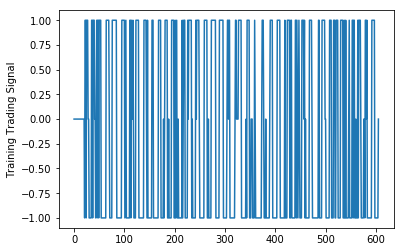

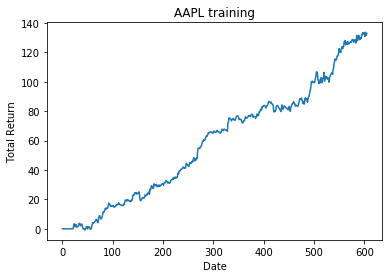

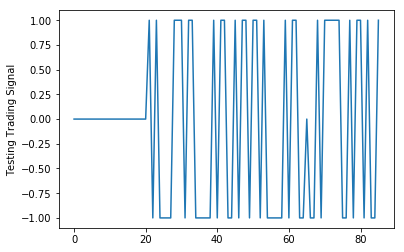

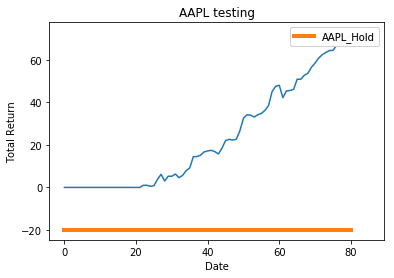

In [231]:
train_test_Model("AAPL", trainingData=aapl_trainingData, testingData=aapl_testingData,
                 length=21, step=1000, coef=0.05, speed=0.3)

Robustness Testing

In [ ]:
#1 AMZN different date

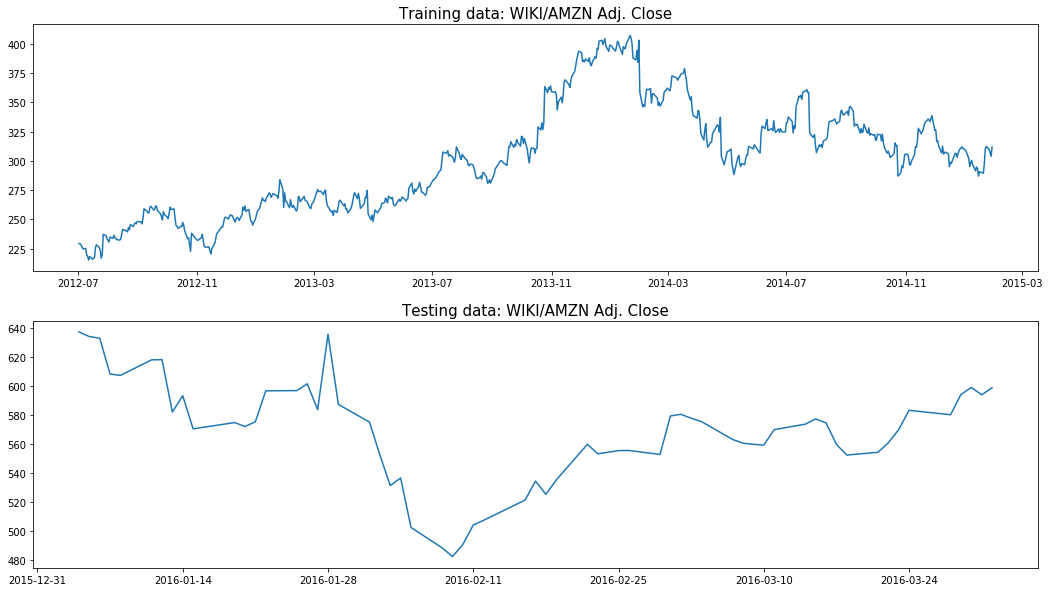

In [47]:
amzn_trainingData, amzn_testingData = acquireData("AMZN","2012-07-01","2015-01-29","2016-01-01","2016-04-01")

Reinforcement Learning 1 th step, Sharp Ratio: -0.08430136744132939
Reinforcement Learning 2 th step, Sharp Ratio: 0.03590047749850593
Reinforcement Learning 3 th step, Sharp Ratio: 0.04976339670118286
Reinforcement Learning 4 th step, Sharp Ratio: 0.05193574908532292
Reinforcement Learning 5 th step, Sharp Ratio: 0.0556762649593446
Reinforcement Learning 6 th step, Sharp Ratio: 0.06134790292737735
Reinforcement Learning 7 th step, Sharp Ratio: 0.0636319948023465
Reinforcement Learning 8 th step, Sharp Ratio: 0.06540398892709669
Reinforcement Learning 9 th step, Sharp Ratio: 0.06703399971368798
Reinforcement Learning 10 th step, Sharp Ratio: 0.06696845610042446
Reinforcement Learning 11 th step, Sharp Ratio: 0.06985091082762575
Reinforcement Learning 12 th step, Sharp Ratio: 0.06985091082762575
Reinforcement Learning 13 th step, Sharp Ratio: 0.06777985573206904
Reinforcement Learning 14 th step, Sharp Ratio: 0.06952899996248896
Reinforcement Learning 15 th step, Sharp Ratio: 0.06679250

Reinforcement Learning 126 th step, Sharp Ratio: 0.12282989353467862
Reinforcement Learning 127 th step, Sharp Ratio: 0.12282989353467862
Reinforcement Learning 128 th step, Sharp Ratio: 0.12326945266765511
Reinforcement Learning 129 th step, Sharp Ratio: 0.12326945266765511
Reinforcement Learning 130 th step, Sharp Ratio: 0.12326945266765511
Reinforcement Learning 131 th step, Sharp Ratio: 0.12326945266765511
Reinforcement Learning 132 th step, Sharp Ratio: 0.12326945266765511
Reinforcement Learning 133 th step, Sharp Ratio: 0.12326945266765511
Reinforcement Learning 134 th step, Sharp Ratio: 0.12326945266765511
Reinforcement Learning 135 th step, Sharp Ratio: 0.12326945266765511
Reinforcement Learning 136 th step, Sharp Ratio: 0.12326945266765511
Reinforcement Learning 137 th step, Sharp Ratio: 0.12326945266765511
Reinforcement Learning 138 th step, Sharp Ratio: 0.12326945266765511
Reinforcement Learning 139 th step, Sharp Ratio: 0.12326945266765511
Reinforcement Learning 140 th step

Reinforcement Learning 248 th step, Sharp Ratio: 0.12430437659226974
Reinforcement Learning 249 th step, Sharp Ratio: 0.12430437659226974
Reinforcement Learning 250 th step, Sharp Ratio: 0.12430437659226974
Reinforcement Learning 251 th step, Sharp Ratio: 0.12430437659226974
Reinforcement Learning 252 th step, Sharp Ratio: 0.12430437659226974
Reinforcement Learning 253 th step, Sharp Ratio: 0.12430437659226974
Reinforcement Learning 254 th step, Sharp Ratio: 0.12430437659226974
Reinforcement Learning 255 th step, Sharp Ratio: 0.12430437659226974
Reinforcement Learning 256 th step, Sharp Ratio: 0.12430437659226974
Reinforcement Learning 257 th step, Sharp Ratio: 0.12430437659226974
Reinforcement Learning 258 th step, Sharp Ratio: 0.12430437659226974
Reinforcement Learning 259 th step, Sharp Ratio: 0.12430437659226974
Reinforcement Learning 260 th step, Sharp Ratio: 0.12430437659226974
Reinforcement Learning 261 th step, Sharp Ratio: 0.12430437659226974
Reinforcement Learning 262 th step

Reinforcement Learning 369 th step, Sharp Ratio: 0.12495697484789253
Reinforcement Learning 370 th step, Sharp Ratio: 0.12642181558665821
Reinforcement Learning 371 th step, Sharp Ratio: 0.12642181558665821
Reinforcement Learning 372 th step, Sharp Ratio: 0.12642181558665821
Reinforcement Learning 373 th step, Sharp Ratio: 0.12824905164068867
Reinforcement Learning 374 th step, Sharp Ratio: 0.12687278713197825
Reinforcement Learning 375 th step, Sharp Ratio: 0.12869968576792035
Reinforcement Learning 376 th step, Sharp Ratio: 0.12869968576792035
Reinforcement Learning 377 th step, Sharp Ratio: 0.12869968576792035
Reinforcement Learning 378 th step, Sharp Ratio: 0.12869968576792035
Reinforcement Learning 379 th step, Sharp Ratio: 0.12869968576792035
Reinforcement Learning 380 th step, Sharp Ratio: 0.12869968576792035
Reinforcement Learning 381 th step, Sharp Ratio: 0.12869968576792035
Reinforcement Learning 382 th step, Sharp Ratio: 0.12869968576792035
Reinforcement Learning 383 th step

Reinforcement Learning 488 th step, Sharp Ratio: 0.13089859468011972
Reinforcement Learning 489 th step, Sharp Ratio: 0.13089859468011972
Reinforcement Learning 490 th step, Sharp Ratio: 0.13089859468011972
Reinforcement Learning 491 th step, Sharp Ratio: 0.13089859468011972
Reinforcement Learning 492 th step, Sharp Ratio: 0.13089859468011972
Reinforcement Learning 493 th step, Sharp Ratio: 0.13089859468011972
Reinforcement Learning 494 th step, Sharp Ratio: 0.13089859468011972
Reinforcement Learning 495 th step, Sharp Ratio: 0.13089859468011972
Reinforcement Learning 496 th step, Sharp Ratio: 0.13089859468011972
Reinforcement Learning 497 th step, Sharp Ratio: 0.13089859468011972
Reinforcement Learning 498 th step, Sharp Ratio: 0.13089859468011972
Reinforcement Learning 499 th step, Sharp Ratio: 0.13089859468011972
Reinforcement Learning 500 th step, Sharp Ratio: 0.13089859468011972
Reinforcement Learning 501 th step, Sharp Ratio: 0.13089859468011972
Reinforcement Learning 502 th step

Reinforcement Learning 609 th step, Sharp Ratio: 0.13047824838688138
Reinforcement Learning 610 th step, Sharp Ratio: 0.13047824838688138
Reinforcement Learning 611 th step, Sharp Ratio: 0.13047824838688138
Reinforcement Learning 612 th step, Sharp Ratio: 0.13047824838688138
Reinforcement Learning 613 th step, Sharp Ratio: 0.132011874128486
Reinforcement Learning 614 th step, Sharp Ratio: 0.13047824838688138
Reinforcement Learning 615 th step, Sharp Ratio: 0.13047824838688138
Reinforcement Learning 616 th step, Sharp Ratio: 0.132011874128486
Reinforcement Learning 617 th step, Sharp Ratio: 0.13047824838688138
Reinforcement Learning 618 th step, Sharp Ratio: 0.13047824838688138
Reinforcement Learning 619 th step, Sharp Ratio: 0.132011874128486
Reinforcement Learning 620 th step, Sharp Ratio: 0.13047824838688138
Reinforcement Learning 621 th step, Sharp Ratio: 0.132011874128486
Reinforcement Learning 622 th step, Sharp Ratio: 0.13047824838688138
Reinforcement Learning 623 th step, Sharp 

Reinforcement Learning 731 th step, Sharp Ratio: 0.13309446806879902
Reinforcement Learning 732 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 733 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 734 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 735 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 736 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 737 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 738 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 739 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 740 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 741 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 742 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 743 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 744 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 745 th step, Sharp Ratio: 0.134101192

Reinforcement Learning 855 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 856 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 857 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 858 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 859 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 860 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 861 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 862 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 863 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 864 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 865 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 866 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 867 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 868 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 869 th step, Sharp Ratio: 0.13410119256

Reinforcement Learning 983 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 984 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 985 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 986 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 987 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 988 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 989 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 990 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 991 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 992 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 993 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 994 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 995 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 996 th step, Sharp Ratio: 0.134101192560108
Reinforcement Learning 997 th step, Sharp Ratio: 0.13410119256

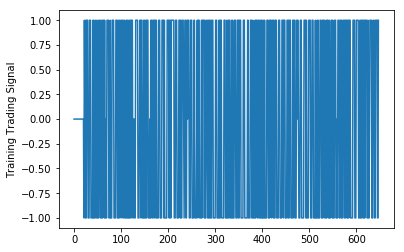

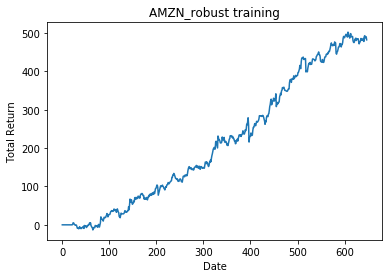

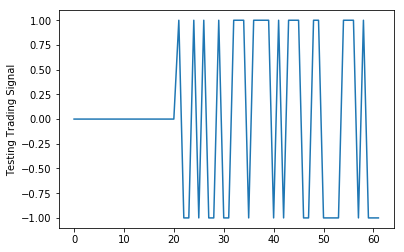

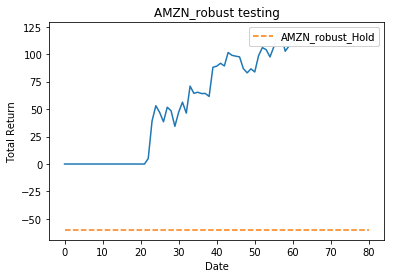

In [50]:
train_test_Model("AMZN_robust", trainingData=amzn_trainingData, testingData=amzn_testingData,
                 length=21, step=1000, coef=0.02, speed=0.3)

In [51]:
#2 AAPL

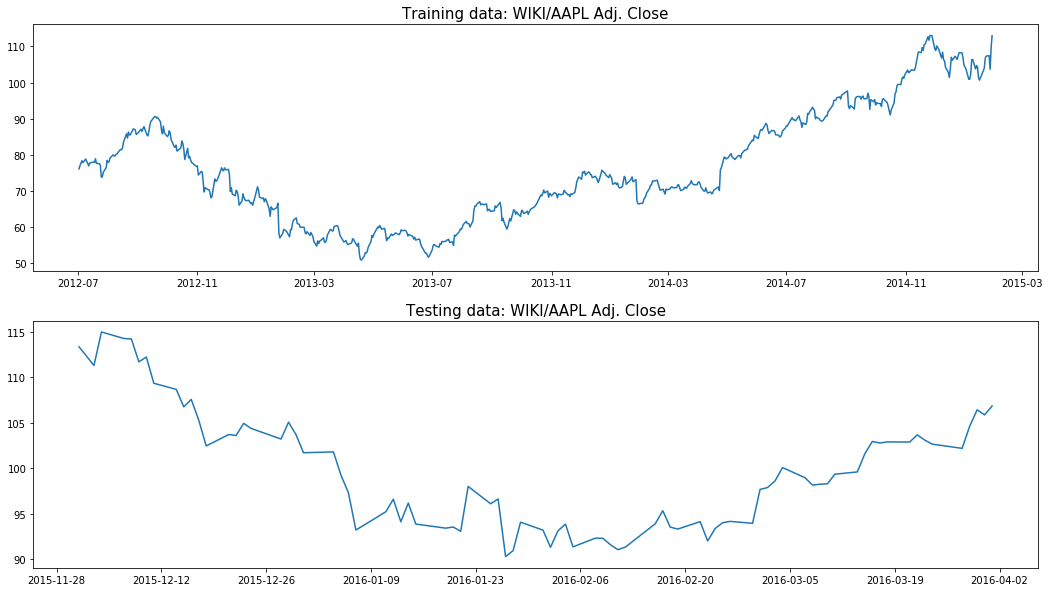

In [52]:
aapl_trainingData, aapl_testingData = acquireData("AAPL","2012-07-01","2015-01-29","2015-12-01","2016-04-01")

Reinforcement Learning 1 th step, Sharp Ratio: -0.0006209270277890714
Reinforcement Learning 2 th step, Sharp Ratio: -0.010909645839581417
Reinforcement Learning 3 th step, Sharp Ratio: 0.060888920456090644
Reinforcement Learning 4 th step, Sharp Ratio: 0.07363842245136666
Reinforcement Learning 5 th step, Sharp Ratio: 0.07683975203788065
Reinforcement Learning 6 th step, Sharp Ratio: 0.08206903082929251
Reinforcement Learning 7 th step, Sharp Ratio: 0.10241143491188336
Reinforcement Learning 8 th step, Sharp Ratio: 0.0980384202994658
Reinforcement Learning 9 th step, Sharp Ratio: 0.09651495120578658
Reinforcement Learning 10 th step, Sharp Ratio: 0.0985053578390067
Reinforcement Learning 11 th step, Sharp Ratio: 0.1031424943893496
Reinforcement Learning 12 th step, Sharp Ratio: 0.11248224674568692
Reinforcement Learning 13 th step, Sharp Ratio: 0.1136040147320249
Reinforcement Learning 14 th step, Sharp Ratio: 0.12623155938353922
Reinforcement Learning 15 th step, Sharp Ratio: 0.12473

Reinforcement Learning 124 th step, Sharp Ratio: 0.14506094083758966
Reinforcement Learning 125 th step, Sharp Ratio: 0.14506094083758966
Reinforcement Learning 126 th step, Sharp Ratio: 0.1452597291206958
Reinforcement Learning 127 th step, Sharp Ratio: 0.14717970660053434
Reinforcement Learning 128 th step, Sharp Ratio: 0.14760453608075425
Reinforcement Learning 129 th step, Sharp Ratio: 0.14718209705847285
Reinforcement Learning 130 th step, Sharp Ratio: 0.149741254936151
Reinforcement Learning 131 th step, Sharp Ratio: 0.149741254936151
Reinforcement Learning 132 th step, Sharp Ratio: 0.149741254936151
Reinforcement Learning 133 th step, Sharp Ratio: 0.14987610218739222
Reinforcement Learning 134 th step, Sharp Ratio: 0.14987610218739222
Reinforcement Learning 135 th step, Sharp Ratio: 0.1538586624082712
Reinforcement Learning 136 th step, Sharp Ratio: 0.15300524807357277
Reinforcement Learning 137 th step, Sharp Ratio: 0.15300524807357277
Reinforcement Learning 138 th step, Sharp 

Reinforcement Learning 246 th step, Sharp Ratio: 0.15249581224807743
Reinforcement Learning 247 th step, Sharp Ratio: 0.15392067456925052
Reinforcement Learning 248 th step, Sharp Ratio: 0.1565384342012633
Reinforcement Learning 249 th step, Sharp Ratio: 0.1564171772574711
Reinforcement Learning 250 th step, Sharp Ratio: 0.1564171772574711
Reinforcement Learning 251 th step, Sharp Ratio: 0.1564171772574711
Reinforcement Learning 252 th step, Sharp Ratio: 0.1564171772574711
Reinforcement Learning 253 th step, Sharp Ratio: 0.1564171772574711
Reinforcement Learning 254 th step, Sharp Ratio: 0.1564171772574711
Reinforcement Learning 255 th step, Sharp Ratio: 0.1564171772574711
Reinforcement Learning 256 th step, Sharp Ratio: 0.1564171772574711
Reinforcement Learning 257 th step, Sharp Ratio: 0.1545739658689431
Reinforcement Learning 258 th step, Sharp Ratio: 0.1532246795299258
Reinforcement Learning 259 th step, Sharp Ratio: 0.1532246795299258
Reinforcement Learning 260 th step, Sharp Rati

Reinforcement Learning 488 th step, Sharp Ratio: 0.162966564351067
Reinforcement Learning 489 th step, Sharp Ratio: 0.162966564351067
Reinforcement Learning 490 th step, Sharp Ratio: 0.162966564351067
Reinforcement Learning 491 th step, Sharp Ratio: 0.162966564351067
Reinforcement Learning 492 th step, Sharp Ratio: 0.1628496054683972
Reinforcement Learning 493 th step, Sharp Ratio: 0.1628496054683972
Reinforcement Learning 494 th step, Sharp Ratio: 0.1628496054683972
Reinforcement Learning 495 th step, Sharp Ratio: 0.1628496054683972
Reinforcement Learning 496 th step, Sharp Ratio: 0.1628496054683972
Reinforcement Learning 497 th step, Sharp Ratio: 0.1628496054683972
Reinforcement Learning 498 th step, Sharp Ratio: 0.1628496054683972
Reinforcement Learning 499 th step, Sharp Ratio: 0.1628496054683972
Reinforcement Learning 500 th step, Sharp Ratio: 0.1628496054683972
Reinforcement Learning 501 th step, Sharp Ratio: 0.1628496054683972
Reinforcement Learning 502 th step, Sharp Ratio: 0.1

Reinforcement Learning 609 th step, Sharp Ratio: 0.16341037605961464
Reinforcement Learning 610 th step, Sharp Ratio: 0.1674077225459638
Reinforcement Learning 611 th step, Sharp Ratio: 0.1615322050380778
Reinforcement Learning 612 th step, Sharp Ratio: 0.16710902286594945
Reinforcement Learning 613 th step, Sharp Ratio: 0.16670064492034015
Reinforcement Learning 614 th step, Sharp Ratio: 0.16710902286594945
Reinforcement Learning 615 th step, Sharp Ratio: 0.16490390532322338
Reinforcement Learning 616 th step, Sharp Ratio: 0.1676200381564234
Reinforcement Learning 617 th step, Sharp Ratio: 0.16580458573846638
Reinforcement Learning 618 th step, Sharp Ratio: 0.16470740268499132
Reinforcement Learning 619 th step, Sharp Ratio: 0.1654493038242832
Reinforcement Learning 620 th step, Sharp Ratio: 0.1620080672287103
Reinforcement Learning 621 th step, Sharp Ratio: 0.16624107157920154
Reinforcement Learning 622 th step, Sharp Ratio: 0.1661050363582116
Reinforcement Learning 623 th step, Shar

Reinforcement Learning 732 th step, Sharp Ratio: 0.16573180703525575
Reinforcement Learning 733 th step, Sharp Ratio: 0.17101541662070843
Reinforcement Learning 734 th step, Sharp Ratio: 0.17065142961460972
Reinforcement Learning 735 th step, Sharp Ratio: 0.17412763668407505
Reinforcement Learning 736 th step, Sharp Ratio: 0.17065142961460972
Reinforcement Learning 737 th step, Sharp Ratio: 0.1725340137121001
Reinforcement Learning 738 th step, Sharp Ratio: 0.16883769818048694
Reinforcement Learning 739 th step, Sharp Ratio: 0.17412763668407505
Reinforcement Learning 740 th step, Sharp Ratio: 0.17065142961460972
Reinforcement Learning 741 th step, Sharp Ratio: 0.17412763668407505
Reinforcement Learning 742 th step, Sharp Ratio: 0.17065142961460972
Reinforcement Learning 743 th step, Sharp Ratio: 0.1725340137121001
Reinforcement Learning 744 th step, Sharp Ratio: 0.1700675140553512
Reinforcement Learning 745 th step, Sharp Ratio: 0.17412763668407505
Reinforcement Learning 746 th step, S

Reinforcement Learning 856 th step, Sharp Ratio: 0.1783798250631985
Reinforcement Learning 857 th step, Sharp Ratio: 0.17308949155681924
Reinforcement Learning 858 th step, Sharp Ratio: 0.1783798250631985
Reinforcement Learning 859 th step, Sharp Ratio: 0.17308949155681924
Reinforcement Learning 860 th step, Sharp Ratio: 0.1767870994084827
Reinforcement Learning 861 th step, Sharp Ratio: 0.17308949155681924
Reinforcement Learning 862 th step, Sharp Ratio: 0.1783798250631985
Reinforcement Learning 863 th step, Sharp Ratio: 0.17308949155681924
Reinforcement Learning 864 th step, Sharp Ratio: 0.17468770380874793
Reinforcement Learning 865 th step, Sharp Ratio: 0.1767870994084827
Reinforcement Learning 866 th step, Sharp Ratio: 0.17308949155681924
Reinforcement Learning 867 th step, Sharp Ratio: 0.1783798250631985
Reinforcement Learning 868 th step, Sharp Ratio: 0.17308949155681924
Reinforcement Learning 869 th step, Sharp Ratio: 0.1783798250631985
Reinforcement Learning 870 th step, Sharp

Reinforcement Learning 980 th step, Sharp Ratio: 0.17224648908846416
Reinforcement Learning 981 th step, Sharp Ratio: 0.17713793742170636
Reinforcement Learning 982 th step, Sharp Ratio: 0.1746812750759375
Reinforcement Learning 983 th step, Sharp Ratio: 0.170985546619758
Reinforcement Learning 984 th step, Sharp Ratio: 0.17713793742170636
Reinforcement Learning 985 th step, Sharp Ratio: 0.170985546619758
Reinforcement Learning 986 th step, Sharp Ratio: 0.17713793742170636
Reinforcement Learning 987 th step, Sharp Ratio: 0.170985546619758
Reinforcement Learning 988 th step, Sharp Ratio: 0.17713793742170636
Reinforcement Learning 989 th step, Sharp Ratio: 0.17224648908846416
Reinforcement Learning 990 th step, Sharp Ratio: 0.17713793742170636
Reinforcement Learning 991 th step, Sharp Ratio: 0.170985546619758
Reinforcement Learning 992 th step, Sharp Ratio: 0.17713793742170636
Reinforcement Learning 993 th step, Sharp Ratio: 0.17224648908846416
Reinforcement Learning 994 th step, Sharp R

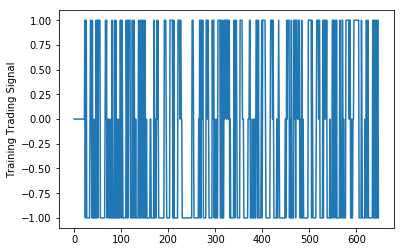

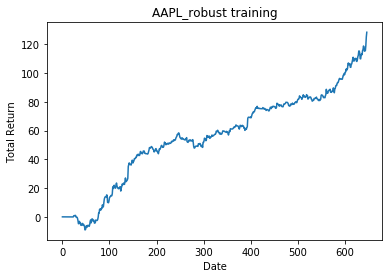

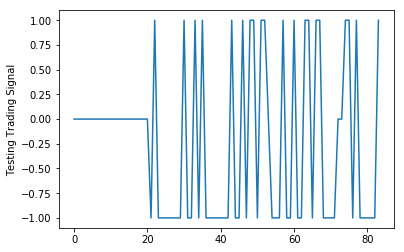

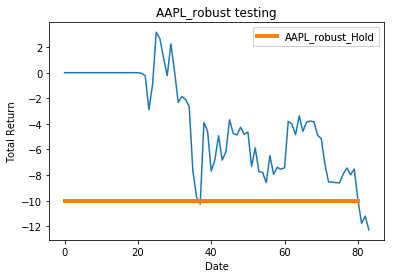

In [53]:
train_test_Model("AAPL_robust", trainingData=aapl_trainingData, testingData=aapl_testingData,
                 length=21, step=1000, coef=0.1, speed=0.3)

In [ ]:
# 3 PEP

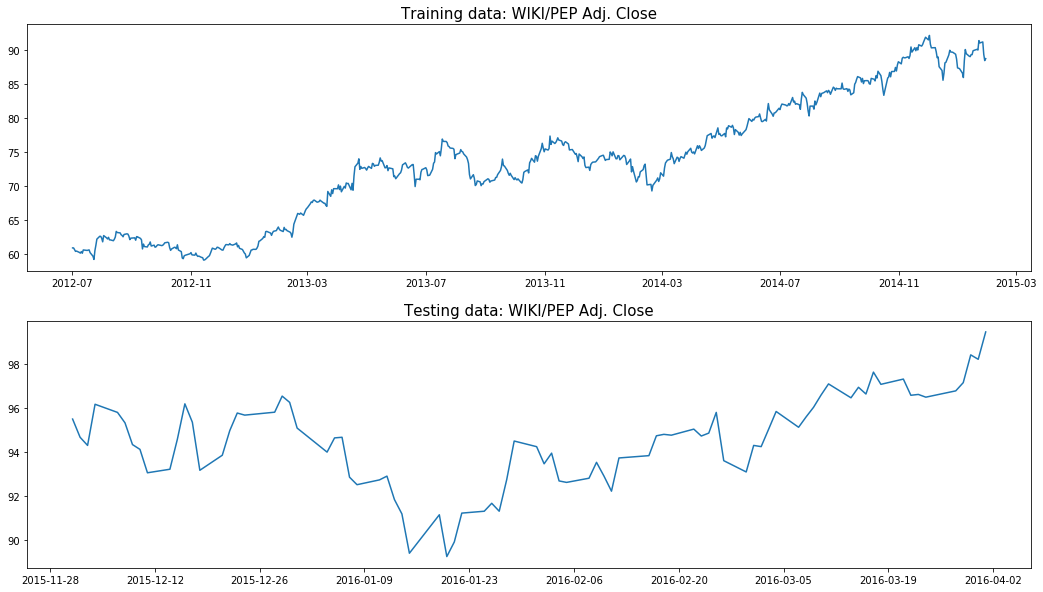

In [54]:
pep_trainingData, pep_testingData = acquireData("PEP","2012-07-01","2015-01-29","2015-12-01","2016-04-01")

Reinforcement Learning 1 th step, Sharp Ratio: -0.03652897826362044
Reinforcement Learning 2 th step, Sharp Ratio: -0.0017633153154939128
Reinforcement Learning 3 th step, Sharp Ratio: 0.019304247040634194
Reinforcement Learning 4 th step, Sharp Ratio: 0.020948613298061407
Reinforcement Learning 5 th step, Sharp Ratio: 0.0316209312649364
Reinforcement Learning 6 th step, Sharp Ratio: 0.034188494413660814
Reinforcement Learning 7 th step, Sharp Ratio: 0.030056894976136
Reinforcement Learning 8 th step, Sharp Ratio: 0.030054866145537713
Reinforcement Learning 9 th step, Sharp Ratio: 0.03441105755494235
Reinforcement Learning 10 th step, Sharp Ratio: 0.027827903351020523
Reinforcement Learning 11 th step, Sharp Ratio: 0.04945343595550387
Reinforcement Learning 12 th step, Sharp Ratio: 0.053788501047030306
Reinforcement Learning 13 th step, Sharp Ratio: 0.05488089086830879
Reinforcement Learning 14 th step, Sharp Ratio: 0.05674141958712776
Reinforcement Learning 15 th step, Sharp Ratio: 0.

Reinforcement Learning 122 th step, Sharp Ratio: 0.08402223018364684
Reinforcement Learning 123 th step, Sharp Ratio: 0.08679194147239515
Reinforcement Learning 124 th step, Sharp Ratio: 0.07949588972700833
Reinforcement Learning 125 th step, Sharp Ratio: 0.08404967028681212
Reinforcement Learning 126 th step, Sharp Ratio: 0.08404967028681212
Reinforcement Learning 127 th step, Sharp Ratio: 0.08360753983496164
Reinforcement Learning 128 th step, Sharp Ratio: 0.08425223094793062
Reinforcement Learning 129 th step, Sharp Ratio: 0.08197780634134912
Reinforcement Learning 130 th step, Sharp Ratio: 0.08180867915078527
Reinforcement Learning 131 th step, Sharp Ratio: 0.07905129926611973
Reinforcement Learning 132 th step, Sharp Ratio: 0.07928586433629174
Reinforcement Learning 133 th step, Sharp Ratio: 0.0787656012357089
Reinforcement Learning 134 th step, Sharp Ratio: 0.0765278368464475
Reinforcement Learning 135 th step, Sharp Ratio: 0.0823428980706357
Reinforcement Learning 136 th step, S

Reinforcement Learning 245 th step, Sharp Ratio: 0.10449790234147119
Reinforcement Learning 246 th step, Sharp Ratio: 0.10614049341665771
Reinforcement Learning 247 th step, Sharp Ratio: 0.10714297172852211
Reinforcement Learning 248 th step, Sharp Ratio: 0.10928152657978642
Reinforcement Learning 249 th step, Sharp Ratio: 0.10510098169066297
Reinforcement Learning 250 th step, Sharp Ratio: 0.10510098169066297
Reinforcement Learning 251 th step, Sharp Ratio: 0.10697913384942567
Reinforcement Learning 252 th step, Sharp Ratio: 0.11090647460567997
Reinforcement Learning 253 th step, Sharp Ratio: 0.11190100951623363
Reinforcement Learning 254 th step, Sharp Ratio: 0.11255244555165607
Reinforcement Learning 255 th step, Sharp Ratio: 0.11255244555165607
Reinforcement Learning 256 th step, Sharp Ratio: 0.11054846196687099
Reinforcement Learning 257 th step, Sharp Ratio: 0.11054846196687099
Reinforcement Learning 258 th step, Sharp Ratio: 0.11054846196687099
Reinforcement Learning 259 th step

Reinforcement Learning 366 th step, Sharp Ratio: 0.10910487196803388
Reinforcement Learning 367 th step, Sharp Ratio: 0.11354490278830912
Reinforcement Learning 368 th step, Sharp Ratio: 0.10890749654657048
Reinforcement Learning 369 th step, Sharp Ratio: 0.11354490278830912
Reinforcement Learning 370 th step, Sharp Ratio: 0.10777744058274621
Reinforcement Learning 371 th step, Sharp Ratio: 0.11242280464750745
Reinforcement Learning 372 th step, Sharp Ratio: 0.10675884224708883
Reinforcement Learning 373 th step, Sharp Ratio: 0.11008689381114099
Reinforcement Learning 374 th step, Sharp Ratio: 0.10855404032795929
Reinforcement Learning 375 th step, Sharp Ratio: 0.11008689381114099
Reinforcement Learning 376 th step, Sharp Ratio: 0.10855404032795929
Reinforcement Learning 377 th step, Sharp Ratio: 0.10855404032795929
Reinforcement Learning 378 th step, Sharp Ratio: 0.11186688357489355
Reinforcement Learning 379 th step, Sharp Ratio: 0.1103326581152937
Reinforcement Learning 380 th step,

Reinforcement Learning 485 th step, Sharp Ratio: 0.1224053456392023
Reinforcement Learning 486 th step, Sharp Ratio: 0.1179483450861946
Reinforcement Learning 487 th step, Sharp Ratio: 0.1224053456392023
Reinforcement Learning 488 th step, Sharp Ratio: 0.1224053456392023
Reinforcement Learning 489 th step, Sharp Ratio: 0.11948691941594287
Reinforcement Learning 490 th step, Sharp Ratio: 0.1224053456392023
Reinforcement Learning 491 th step, Sharp Ratio: 0.11221071092535277
Reinforcement Learning 492 th step, Sharp Ratio: 0.12040682971490647
Reinforcement Learning 493 th step, Sharp Ratio: 0.12040682971490647
Reinforcement Learning 494 th step, Sharp Ratio: 0.12040682971490647
Reinforcement Learning 495 th step, Sharp Ratio: 0.1196655237712178
Reinforcement Learning 496 th step, Sharp Ratio: 0.1196655237712178
Reinforcement Learning 497 th step, Sharp Ratio: 0.1196655237712178
Reinforcement Learning 498 th step, Sharp Ratio: 0.1196655237712178
Reinforcement Learning 499 th step, Sharp R

Reinforcement Learning 608 th step, Sharp Ratio: 0.1171202282295324
Reinforcement Learning 609 th step, Sharp Ratio: 0.11767372899771997
Reinforcement Learning 610 th step, Sharp Ratio: 0.12432847366229516
Reinforcement Learning 611 th step, Sharp Ratio: 0.11255149655193039
Reinforcement Learning 612 th step, Sharp Ratio: 0.11985896320430893
Reinforcement Learning 613 th step, Sharp Ratio: 0.12040351432608598
Reinforcement Learning 614 th step, Sharp Ratio: 0.11985896320430893
Reinforcement Learning 615 th step, Sharp Ratio: 0.12040351432608598
Reinforcement Learning 616 th step, Sharp Ratio: 0.12040351432608598
Reinforcement Learning 617 th step, Sharp Ratio: 0.12010248931155415
Reinforcement Learning 618 th step, Sharp Ratio: 0.12010248931155415
Reinforcement Learning 619 th step, Sharp Ratio: 0.1156533897079581
Reinforcement Learning 620 th step, Sharp Ratio: 0.1195569261123813
Reinforcement Learning 621 th step, Sharp Ratio: 0.12010248931155415
Reinforcement Learning 622 th step, S

Reinforcement Learning 732 th step, Sharp Ratio: 0.12846251807512998
Reinforcement Learning 733 th step, Sharp Ratio: 0.12736542549245075
Reinforcement Learning 734 th step, Sharp Ratio: 0.12846251807512998
Reinforcement Learning 735 th step, Sharp Ratio: 0.12736542549245075
Reinforcement Learning 736 th step, Sharp Ratio: 0.12846251807512998
Reinforcement Learning 737 th step, Sharp Ratio: 0.12846251807512998
Reinforcement Learning 738 th step, Sharp Ratio: 0.12736542549245075
Reinforcement Learning 739 th step, Sharp Ratio: 0.12846251807512998
Reinforcement Learning 740 th step, Sharp Ratio: 0.12846251807512998
Reinforcement Learning 741 th step, Sharp Ratio: 0.12846251807512998
Reinforcement Learning 742 th step, Sharp Ratio: 0.12846251807512998
Reinforcement Learning 743 th step, Sharp Ratio: 0.12846251807512998
Reinforcement Learning 744 th step, Sharp Ratio: 0.12846251807512998
Reinforcement Learning 745 th step, Sharp Ratio: 0.12846251807512998
Reinforcement Learning 746 th step

Reinforcement Learning 854 th step, Sharp Ratio: 0.13485253121567517
Reinforcement Learning 855 th step, Sharp Ratio: 0.13485253121567517
Reinforcement Learning 856 th step, Sharp Ratio: 0.13485253121567517
Reinforcement Learning 857 th step, Sharp Ratio: 0.13485253121567517
Reinforcement Learning 858 th step, Sharp Ratio: 0.13763684952119293
Reinforcement Learning 859 th step, Sharp Ratio: 0.13485253121567517
Reinforcement Learning 860 th step, Sharp Ratio: 0.13485253121567517
Reinforcement Learning 861 th step, Sharp Ratio: 0.13485253121567517
Reinforcement Learning 862 th step, Sharp Ratio: 0.13556058555042136
Reinforcement Learning 863 th step, Sharp Ratio: 0.13834295585783768
Reinforcement Learning 864 th step, Sharp Ratio: 0.13556058555042136
Reinforcement Learning 865 th step, Sharp Ratio: 0.13556058555042136
Reinforcement Learning 866 th step, Sharp Ratio: 0.13556058555042136
Reinforcement Learning 867 th step, Sharp Ratio: 0.1354285383105849
Reinforcement Learning 868 th step,

Reinforcement Learning 976 th step, Sharp Ratio: 0.14012567757549846
Reinforcement Learning 977 th step, Sharp Ratio: 0.13734640594933437
Reinforcement Learning 978 th step, Sharp Ratio: 0.13734640594933437
Reinforcement Learning 979 th step, Sharp Ratio: 0.14012567757549846
Reinforcement Learning 980 th step, Sharp Ratio: 0.13734640594933437
Reinforcement Learning 981 th step, Sharp Ratio: 0.13734640594933437
Reinforcement Learning 982 th step, Sharp Ratio: 0.13734640594933437
Reinforcement Learning 983 th step, Sharp Ratio: 0.14091291269509554
Reinforcement Learning 984 th step, Sharp Ratio: 0.13734640594933437
Reinforcement Learning 985 th step, Sharp Ratio: 0.13734640594933437
Reinforcement Learning 986 th step, Sharp Ratio: 0.14012567757549846
Reinforcement Learning 987 th step, Sharp Ratio: 0.13734640594933437
Reinforcement Learning 988 th step, Sharp Ratio: 0.13734640594933437
Reinforcement Learning 989 th step, Sharp Ratio: 0.14012567757549846
Reinforcement Learning 990 th step

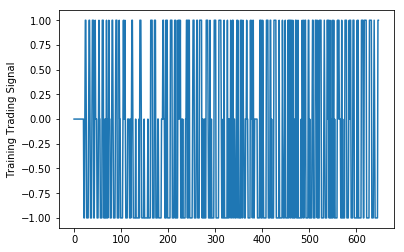

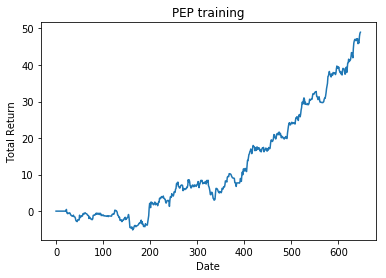

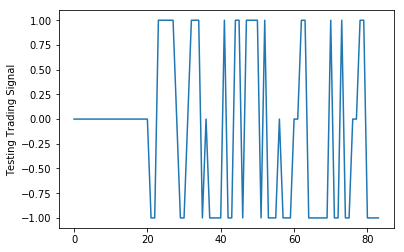

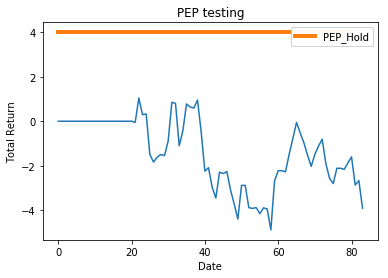

In [58]:
train_test_Model("PEP", trainingData=pep_trainingData, testingData=pep_testingData,
                 length=21, step=1000, coef=0.2, speed=0.3)

In [ ]:
# 4 NVDA

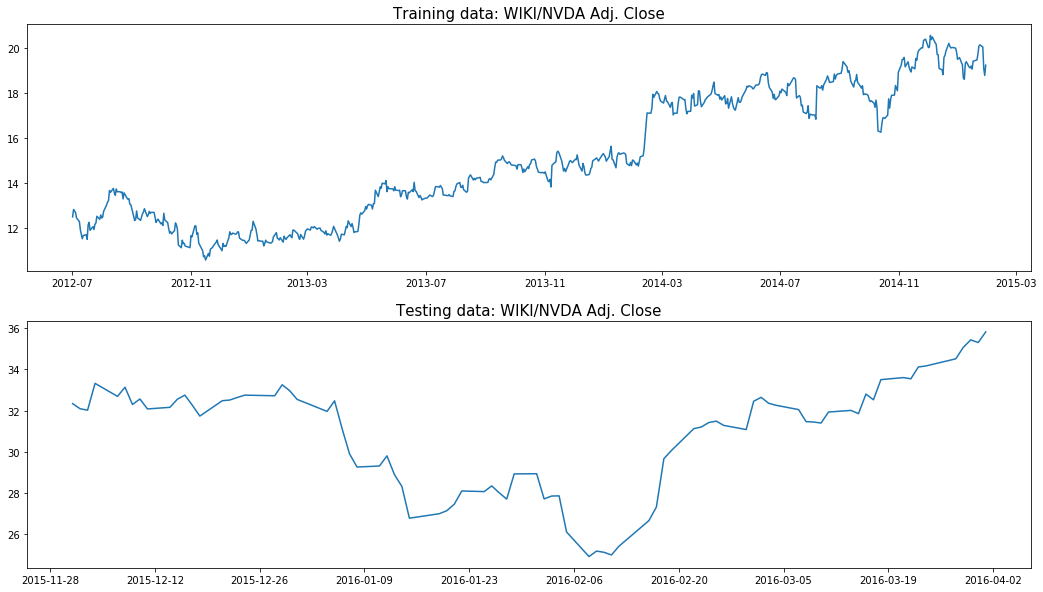

In [59]:
nvda_trainingData, nvda_testingData = acquireData("NVDA","2012-07-01","2015-01-29","2015-12-01","2016-04-01")

Reinforcement Learning 1 th step, Sharp Ratio: -0.009191278110994416
Reinforcement Learning 2 th step, Sharp Ratio: -0.035791190482450864
Reinforcement Learning 3 th step, Sharp Ratio: -0.010442432968697879
Reinforcement Learning 4 th step, Sharp Ratio: -0.04192840239573323
Reinforcement Learning 5 th step, Sharp Ratio: -0.02898629608101824
Reinforcement Learning 6 th step, Sharp Ratio: -0.024069938117248373
Reinforcement Learning 7 th step, Sharp Ratio: 0.00034362298114061854
Reinforcement Learning 8 th step, Sharp Ratio: 0.008927202808494903
Reinforcement Learning 9 th step, Sharp Ratio: 0.018140008983918186
Reinforcement Learning 10 th step, Sharp Ratio: 0.017187948863111403
Reinforcement Learning 11 th step, Sharp Ratio: 0.01811934376619206
Reinforcement Learning 12 th step, Sharp Ratio: 0.02382615343378659
Reinforcement Learning 13 th step, Sharp Ratio: 0.02382615343378659
Reinforcement Learning 14 th step, Sharp Ratio: 0.02829310950879548
Reinforcement Learning 15 th step, Sharp 

Reinforcement Learning 125 th step, Sharp Ratio: 0.016528699414663055
Reinforcement Learning 126 th step, Sharp Ratio: 0.01952502102699782
Reinforcement Learning 127 th step, Sharp Ratio: 0.019003557303503046
Reinforcement Learning 128 th step, Sharp Ratio: 0.019003557303503046
Reinforcement Learning 129 th step, Sharp Ratio: 0.014783579161532629
Reinforcement Learning 130 th step, Sharp Ratio: 0.019003557303503046
Reinforcement Learning 131 th step, Sharp Ratio: 0.014783579161532629
Reinforcement Learning 132 th step, Sharp Ratio: 0.01812174454671655
Reinforcement Learning 133 th step, Sharp Ratio: 0.01812174454671655
Reinforcement Learning 134 th step, Sharp Ratio: 0.012183851992509495
Reinforcement Learning 135 th step, Sharp Ratio: 0.01214427756766746
Reinforcement Learning 136 th step, Sharp Ratio: 0.012575698352355811
Reinforcement Learning 137 th step, Sharp Ratio: 0.013670149857548181
Reinforcement Learning 138 th step, Sharp Ratio: 0.02206867864609317
Reinforcement Learning 13

Reinforcement Learning 247 th step, Sharp Ratio: 0.01861622402629872
Reinforcement Learning 248 th step, Sharp Ratio: 0.018537722187289777
Reinforcement Learning 249 th step, Sharp Ratio: 0.018537722187289777
Reinforcement Learning 250 th step, Sharp Ratio: 0.015448805432022067
Reinforcement Learning 251 th step, Sharp Ratio: 0.020273671670705234
Reinforcement Learning 252 th step, Sharp Ratio: 0.020273671670705234
Reinforcement Learning 253 th step, Sharp Ratio: 0.015448805432022067
Reinforcement Learning 254 th step, Sharp Ratio: 0.018455674199184646
Reinforcement Learning 255 th step, Sharp Ratio: 0.018455674199184646
Reinforcement Learning 256 th step, Sharp Ratio: 0.018455674199184646
Reinforcement Learning 257 th step, Sharp Ratio: 0.018455674199184646
Reinforcement Learning 258 th step, Sharp Ratio: 0.018455674199184646
Reinforcement Learning 259 th step, Sharp Ratio: 0.018455674199184646
Reinforcement Learning 260 th step, Sharp Ratio: 0.018455674199184646
Reinforcement Learnin

Reinforcement Learning 365 th step, Sharp Ratio: 0.02586696365077298
Reinforcement Learning 366 th step, Sharp Ratio: 0.024180725975500226
Reinforcement Learning 367 th step, Sharp Ratio: 0.023122848217528663
Reinforcement Learning 368 th step, Sharp Ratio: 0.023122848217528663
Reinforcement Learning 369 th step, Sharp Ratio: 0.023122848217528663
Reinforcement Learning 370 th step, Sharp Ratio: 0.023122848217528663
Reinforcement Learning 371 th step, Sharp Ratio: 0.023122848217528663
Reinforcement Learning 372 th step, Sharp Ratio: 0.023131093591160473
Reinforcement Learning 373 th step, Sharp Ratio: 0.023938304626218397
Reinforcement Learning 374 th step, Sharp Ratio: 0.023938304626218397
Reinforcement Learning 375 th step, Sharp Ratio: 0.026823748586073618
Reinforcement Learning 376 th step, Sharp Ratio: 0.026823748586073618
Reinforcement Learning 377 th step, Sharp Ratio: 0.026823748586073618
Reinforcement Learning 378 th step, Sharp Ratio: 0.024614592241891997
Reinforcement Learnin

Reinforcement Learning 486 th step, Sharp Ratio: 0.041396331906265446
Reinforcement Learning 487 th step, Sharp Ratio: 0.02943052651251053
Reinforcement Learning 488 th step, Sharp Ratio: 0.024649126442547638
Reinforcement Learning 489 th step, Sharp Ratio: 0.024649126442547638
Reinforcement Learning 490 th step, Sharp Ratio: 0.024649126442547638
Reinforcement Learning 491 th step, Sharp Ratio: 0.024649126442547638
Reinforcement Learning 492 th step, Sharp Ratio: 0.026159422428437957
Reinforcement Learning 493 th step, Sharp Ratio: 0.026159422428437957
Reinforcement Learning 494 th step, Sharp Ratio: 0.026469064975801444
Reinforcement Learning 495 th step, Sharp Ratio: 0.03234595701693814
Reinforcement Learning 496 th step, Sharp Ratio: 0.023634499070928232
Reinforcement Learning 497 th step, Sharp Ratio: 0.016857656129108136
Reinforcement Learning 498 th step, Sharp Ratio: 0.03346519110447331
Reinforcement Learning 499 th step, Sharp Ratio: 0.020549236862284263
Reinforcement Learning 

Reinforcement Learning 605 th step, Sharp Ratio: 0.021429522399441785
Reinforcement Learning 606 th step, Sharp Ratio: 0.02526130442264212
Reinforcement Learning 607 th step, Sharp Ratio: 0.0315834717671938
Reinforcement Learning 608 th step, Sharp Ratio: 0.020702131000188573
Reinforcement Learning 609 th step, Sharp Ratio: 0.0315834717671938
Reinforcement Learning 610 th step, Sharp Ratio: 0.020702131000188573
Reinforcement Learning 611 th step, Sharp Ratio: 0.03021243952360923
Reinforcement Learning 612 th step, Sharp Ratio: 0.027947066139252158
Reinforcement Learning 613 th step, Sharp Ratio: 0.018127524639555647
Reinforcement Learning 614 th step, Sharp Ratio: 0.0284781209968746
Reinforcement Learning 615 th step, Sharp Ratio: 0.025925701504197485
Reinforcement Learning 616 th step, Sharp Ratio: 0.02166506447826696
Reinforcement Learning 617 th step, Sharp Ratio: 0.027126523990976946
Reinforcement Learning 618 th step, Sharp Ratio: 0.027126523990976946
Reinforcement Learning 619 th

Reinforcement Learning 727 th step, Sharp Ratio: 0.042960506331445485
Reinforcement Learning 728 th step, Sharp Ratio: 0.03867752298382893
Reinforcement Learning 729 th step, Sharp Ratio: 0.03458304250976503
Reinforcement Learning 730 th step, Sharp Ratio: 0.040060838734128065
Reinforcement Learning 731 th step, Sharp Ratio: 0.03458304250976503
Reinforcement Learning 732 th step, Sharp Ratio: 0.040060838734128065
Reinforcement Learning 733 th step, Sharp Ratio: 0.03633627619659598
Reinforcement Learning 734 th step, Sharp Ratio: 0.03633627619659598
Reinforcement Learning 735 th step, Sharp Ratio: 0.04075228215893076
Reinforcement Learning 736 th step, Sharp Ratio: 0.03633627619659598
Reinforcement Learning 737 th step, Sharp Ratio: 0.037032614115289145
Reinforcement Learning 738 th step, Sharp Ratio: 0.032924465558338875
Reinforcement Learning 739 th step, Sharp Ratio: 0.037032614115289145
Reinforcement Learning 740 th step, Sharp Ratio: 0.03362132493848378
Reinforcement Learning 741 t

Reinforcement Learning 849 th step, Sharp Ratio: 0.015559298470585719
Reinforcement Learning 850 th step, Sharp Ratio: 0.036375926832215064
Reinforcement Learning 851 th step, Sharp Ratio: 0.023097787608979896
Reinforcement Learning 852 th step, Sharp Ratio: 0.036375926832215064
Reinforcement Learning 853 th step, Sharp Ratio: 0.015559298470585719
Reinforcement Learning 854 th step, Sharp Ratio: 0.036862584727026186
Reinforcement Learning 855 th step, Sharp Ratio: 0.03807735363287497
Reinforcement Learning 856 th step, Sharp Ratio: 0.017402232047869302
Reinforcement Learning 857 th step, Sharp Ratio: 0.03990446788658918
Reinforcement Learning 858 th step, Sharp Ratio: 0.02745018649819094
Reinforcement Learning 859 th step, Sharp Ratio: 0.039850357648597075
Reinforcement Learning 860 th step, Sharp Ratio: 0.017402232047869302
Reinforcement Learning 861 th step, Sharp Ratio: 0.041677149526709215
Reinforcement Learning 862 th step, Sharp Ratio: 0.017402232047869302
Reinforcement Learning 

Reinforcement Learning 972 th step, Sharp Ratio: 0.05591895885891535
Reinforcement Learning 973 th step, Sharp Ratio: 0.052610534393570614
Reinforcement Learning 974 th step, Sharp Ratio: 0.05119738298727004
Reinforcement Learning 975 th step, Sharp Ratio: 0.05348967468843417
Reinforcement Learning 976 th step, Sharp Ratio: 0.03050106037219731
Reinforcement Learning 977 th step, Sharp Ratio: 0.05961616554801041
Reinforcement Learning 978 th step, Sharp Ratio: 0.060147070654766925
Reinforcement Learning 979 th step, Sharp Ratio: 0.055105166048914786
Reinforcement Learning 980 th step, Sharp Ratio: 0.05591895885891535
Reinforcement Learning 981 th step, Sharp Ratio: 0.05679574159944914
Reinforcement Learning 982 th step, Sharp Ratio: 0.05679574159944914
Reinforcement Learning 983 th step, Sharp Ratio: 0.05867521727433971
Reinforcement Learning 984 th step, Sharp Ratio: 0.03361186656022811
Reinforcement Learning 985 th step, Sharp Ratio: 0.055105166048914786
Reinforcement Learning 986 th 

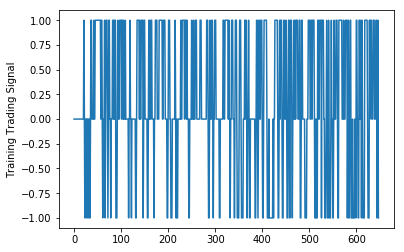

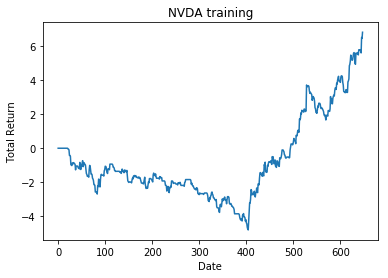

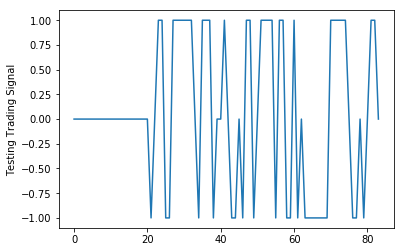

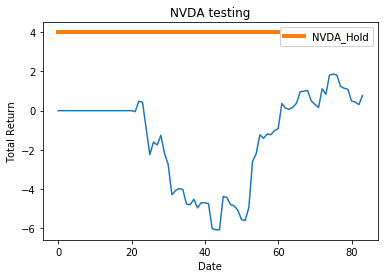

In [63]:
train_test_Model("NVDA", trainingData=nvda_trainingData, testingData=nvda_testingData,
                 length=21, step=1000, coef=0.3, speed=0.3)